# Study - Deorbiting
This code intends to study the deorbiting strategies for a 3U Cubesat through orbital mechanics.  
The variables of interest are:
<ul>
    <li><b>Propellant Usage:</b> the approximate amount of propellant used for the different deorbiting strategies.</li>
    <li><b>Energy:</b> the approximate amount of power and energy used by the thruster in order to perform the maneuver.</li>
    <li><b>Time:</b> the amount of time needed for deorbiting on each scenario.</li>
</ul>

In [2]:
import sys
sys.path.append("../../src")
from maneuvers import Maneuvers
import auxiliary
import constants
import models
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

# COMMON DEFINITIONS
scenarios = {}

cubesat3U = models.Spacecraft(3.9,3.8,10e-2*10e-2)

cubesat3Uv = models.Spacecraft(3.9,3.9-450e-3,10e-2*10e-2)
cubesat3Uv.thruster = models.VikiThruster()
cubesat3Uv.solarPanels = models.DHV_CS_10(3)
cubesat3Uv.battery = models.NanoPowerBP4("2P-2S")

cubesat3Uc = models.Spacecraft(3.9,3.9-50e-3,10e-2*10e-2)
cubesat3Uc.thruster = models.NanoPropCGP3()
cubesat3Uc.solarPanels = models.DHV_CS_10(3)
cubesat3Uc.battery = models.NanoPowerBP4("2P-2S")

# INITIAL CONDITIONS
date = datetime(year=2018,month=8,day=1)

<IPython.core.display.Javascript object>

In [3]:
%%html
<style>
div.output_scroll{
    height: 5em;
    scroll-behavior: auto;
}
</style>

## Harris Priester Model

In [9]:
# Case 1: Free Fall
coe = [constants.Re+495e3,0.00075,0,0,0,np.pi]
# MANEUVERING
scenarios["1"] = Maneuvers(coe,cubesat3U,date,verbose=True)
scenarios["1"].addPerturbation("atmosphere")
T = 2*np.pi*(scenarios["1"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["1"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 1: Free Fall"
#----------------------------------------------------
# Case 2.1: Spiral Descent, VikiThruster
coe = [constants.Re+490e3,0.0014,0,0,0,np.pi]
# MANEUVERING
scenarios["2.1"] = Maneuvers(coe,cubesat3Uv,date,verbose=True)
scenarios["2.1"].addPerturbation("atmosphere")
scenarios["2.1"].addPerturbation("thrust")
scenarios["2.1"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    return np.arctan2(e*np.sin(nu),1+e*np.cos(nu))+np.pi
def betaCallback(coe):
    return 0
scenarios["2.1"].thrustProfile = (alphaCallback,betaCallback)
scenarios["2.1"].propagate(60*60*24,60,max_step=10)

scenarios["2.1"].removePerturbation("thrust")
scenarios["2.1"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["2.1"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["2.1"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 2.1: Spiral Descent, VikiThruster"
#----------------------------------------------------
# Case 2.2: Spiral Descent, Commercial Thruster
# MANEUVERING
scenarios["2.2"] = Maneuvers(coe,cubesat3Uc,date,verbose=True)
scenarios["2.2"].addPerturbation("atmosphere")
scenarios["2.2"].addPerturbation("thrust")
scenarios["2.2"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    return np.arctan2(e*np.sin(nu),1+e*np.cos(nu))+np.pi
def betaCallback(coe):
    return 0
scenarios["2.2"].thrustProfile = (alphaCallback,betaCallback)
scenarios["2.2"].propagate(60*60*24,60,max_step=10)

scenarios["2.2"].removePerturbation("thrust")
scenarios["2.2"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["2.2"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["2.2"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 2.2: Spiral Descent, Commercial Thruster"

#----------------------------------------------------
# 4.1 Hohmann-style Descent, VikiThruster
# MANEUVERING
scenarios["3.1"] = Maneuvers(coe,cubesat3Uv,date,verbose=True)
scenarios["3.1"].addPerturbation("atmosphere")
scenarios["3.1"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    return np.arctan2(e*np.sin(nu),1+e*np.cos(nu))+np.pi
def betaCallback(coe):
    return 0
# -- SCENARIO START --
# 30s Thrust Time
thrustTime = 30
# Initial Propagation
scenarios["3.1"].propagate(thrustTime/2,1)
while True:
    T = 2*np.pi*(scenarios["3.1"].history.coe[-1,0]**3/constants.mu_E)**0.5
    #Propagate to Apogee/Perigee - thrustTime/2 of previous thrust - thrustTime/2 of current thrust
    startTimeThrust = T/2-thrustTime
    scenarios["3.1"].propagate(startTimeThrust,60,max_step=10)
    # Thrust for <thrustTime>
    scenarios["3.1"].addPerturbation("thrust")
    scenarios["3.1"].thrustProfile = (alphaCallback,betaCallback)
    scenarios["3.1"].propagate(thrustTime,1,max_step=1)
    scenarios["3.1"].removePerturbation("thrust")
    #print(scenarios["3.1"].history.propMass[-1])
    if scenarios["3.1"].history.propMass[-1] < 1e-3:
        break;
scenarios["3.1"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["3.1"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["3.1"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 3.1: Hohmann-style Descent, VikiThruster"

#----------------------------------------------------
# 4.2 Hohmann-style Descent, Commercial Thruster
# MANEUVERING
scenarios["3.2"] = Maneuvers(coe,cubesat3Uc,date,verbose=True)
scenarios["3.2"].addPerturbation("atmosphere")
scenarios["3.2"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    return np.arctan2(e*np.sin(nu),1+e*np.cos(nu))+np.pi
def betaCallback(coe):
    return 0
# -- SCENARIO START --
# 30s Thrust Time
thrustTime = 30
# Initial Propagation
scenarios["3.2"].propagate(thrustTime/2,1)
while True:
    T = 2*np.pi*(scenarios["3.2"].history.coe[-1,0]**3/constants.mu_E)**0.5
    #Propagate to Apogee/Perigee - thrustTime/2 of previous thrust - thrustTime/2 of current thrust
    startTimeThrust = T/2-thrustTime
    scenarios["3.2"].propagate(startTimeThrust,60,max_step=10)
    # Thrust for <thrustTime>
    scenarios["3.2"].addPerturbation("thrust")
    scenarios["3.2"].thrustProfile = (alphaCallback,betaCallback)
    scenarios["3.2"].propagate(thrustTime,1,max_step=1)
    scenarios["3.2"].removePerturbation("thrust")
    #print(scenarios["4.2"].history.propMass[-1])
    if scenarios["3.2"].history.propMass[-1] < 1e-3:
        break;
scenarios["3.2"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["3.2"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["3.2"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 3.2: Hohmann-style Descent, Commercial Thruster"

#----------------------------------------------------
# Case 4: Eccentricity Variation Descent
# MANEUVERING
cubesat3Uc2 = models.Spacecraft(3.9,3.9-0.15,10e-2*10e-2)
cubesat3Uc2.thruster = models.NanoPropCGP3()
cubesat3Uc2.solarPanels = models.DHV_CS_10(3)
cubesat3Uc2.battery = models.NanoPowerBP4("2P-2S")
scenarios["4.1"] = Maneuvers(coe,cubesat3Uc2,date,verbose=True)
scenarios["4.1"].addPerturbation("atmosphere")
scenarios["4.1"].addPerturbation("thrust")
scenarios["4.1"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    E = 2*np.arctan2(np.tan(nu/2),np.sqrt((1+e)/(1-e)))
    return np.arctan2(np.sin(nu),np.cos(nu)+np.cos(E))
def betaCallback(coe):
    return 0
scenarios["4.1"].thrustProfile = (alphaCallback,betaCallback)
scenarios["4.1"].propagate(60*60*24*4,60,max_step=10)
scenarios["4.1"].removePerturbation("thrust")
scenarios["4.1"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["4.1"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["4.1"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 4: Eccentricity Variation Descent"

Propagating...from day  0.0  to  3650.0
Day: 2727.001	Altitude: 238.027 km	Mass: 0.100
A termination event occurred. (Status Code: 1)
100.0%



<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  1.0
Day: 0.001	Altitude: 499.567 km	Mass: 0.444
A termination event occurred. (Status Code: 1)
100.0%

Propagating...from day  0.07574704656011119  to  3650.07574704656
Day: 2174.001	Altitude: 235.447 km	Mass: 0.004
A termination event occurred. (Status Code: 1)
100.0%



<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  1.0
Day: 0.001	Altitude: 499.567 km	Mass: 0.050
A termination event occurred. (Status Code: 1)
100.0%

Propagating...from day  0.5670604586518416  to  3650.5670604586517
Day: 2158.001	Altitude: 220.015 km	Mass: 0.000
A termination event occurred. (Status Code: 1)
100.0%



<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  0.00017361111111111112
Day: 0.000	Altitude: 499.614 km	Mass: 0.450
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.00017361111111111112  to  0.032623189329090835
Day: 0.001	Altitude: 499.561 km	Mass: 0.450
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.032623189329090835  to  0.032970411551313056

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.032970411551313056  to  0.06541953279409879

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.06541953279409879  to  0.06576675501632101

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.06576675501632101  to  0.09821542032561609

The solver successfully reache


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.8523942707297766  to  0.8527414929519987

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.8527414929519987  to  0.885179129765077

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.885179129765077  to  0.8855263519872992

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.8855263519872992  to  0.9179635256555425

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9179635256555425  to  0.9183107478777647

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9183107478777647  to  0.9507474594556071

The solver successfully reach

Propagating...from day  1.7049968788871006  to  1.737422411969878

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.737422411969878  to  1.7377696341921

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.7377696341921  to  1.7701946977860785

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.7701946977860785  to  1.7705419200083006

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.7705419200083006  to  1.8029665151799998

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8029665151799998  to  1.8033137374022221

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8033137374


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.654868295872787  to  2.655215518095009

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.655215518095009  to  2.687627353040964

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.687627353040964  to  2.6879745752631856

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.6879745752631856  to  2.7203859347654475

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.7203859347654475  to  2.7207331569876696

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.7207331569876696  to  2.753144039456797

The solver successfully reached t

Propagating...from day  3.5064483874488794  to  3.506795609671102

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.506795609671102  to  3.539194982090247

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.539194982090247  to  3.5395422043124696

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.5395422043124696  to  3.571941094572386

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.571941094572386  to  3.5722883167946087

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.5722883167946087  to  3.6046867232794715

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.60468672


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.423169668886523  to  4.423516891108744

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.423516891108744  to  4.455902643918862

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.455902643918862  to  4.456249866141084

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.456249866141084  to  4.488635129339589

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.488635129339589  to  4.488982351561812

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.488982351561812  to  4.521367123503437

The solver successfully reached the end


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.274066972680037  to  5.274414194902259

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.274414194902259  to  5.3067871111017455

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.3067871111017455  to  5.307134333323967

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.307134333323967  to  5.339506752777962

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.339506752777962  to  5.339853975000184

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.339853975000184  to  5.372225896035425

The solver successfully reached the e


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.222748007823628  to  6.22309523004585

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.22309523004585  to  6.255453606653609

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.255453606653609  to  6.255800828875831

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.255800828875831  to  6.2881586991094105

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.2881586991094105  to  6.288505921331633

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.288505921331633  to  6.32086328631982

The solver successfully reached the end 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.072928471590099  to  7.07327569381232

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.07327569381232  to  7.105620828461803

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.105620828461803  to  7.105968050684026

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.105968050684026  to  7.138312671336364

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.138312671336364  to  7.138659893558587

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.138659893558587  to  7.171004001354929

The solver successfully reached the end o

<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  0.00017361111111111112
Day: 0.000	Altitude: 499.614 km	Mass: 0.050
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.00017361111111111112  to  0.032623189329090835
Day: 0.001	Altitude: 499.561 km	Mass: 0.050
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.032623189329090835  to  0.032970411551313056

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.032970411551313056  to  0.06541988775460784

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.06541988775460784  to  0.06576710997683007

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.06576710997683007  to  0.09821648445142529

The solver successfully reache


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.8853042392610065  to  0.8856514614832287

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.8856514614832287  to  0.9180982886948786

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9180982886948786  to  0.9184455109171008

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9184455109171008  to  0.9508922363760273

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9508922363760273  to  0.9512394585982494

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9512394585982494  to  0.9836860820149459

The solver successfully rea


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.7707078072142137  to  1.771055029436436

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.771055029436436  to  1.8034991052364493

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8034991052364493  to  1.8038463274586716

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8038463274586716  to  1.8362903011907106

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8362903011907106  to  1.8366375234129328

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8366375234129328  to  1.869081395365664

The solver successfully reache


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.62324842637789  to  2.623595648600112

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.623595648600112  to  2.656037074083786

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.656037074083786  to  2.6563842963060087

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.6563842963060087  to  2.68882561969631

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.68882561969631  to  2.6891728419185323

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.6891728419185323  to  2.721614063504225

The solver successfully reached the en

Propagating...from day  3.4760673512574005  to  3.50850612576167

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.50850612576167  to  3.5088533479838926

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.5088533479838926  to  3.5412920203691747

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.5412920203691747  to  3.541639242591397

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.541639242591397  to  3.574077813146555

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.574077813146555  to  3.5744250353687774

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.5744250353


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.328122897885746  to  4.328470120107968

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.328470120107968  to  4.360906242964643

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.360906242964643  to  4.3612534651868655

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.3612534651868655  to  4.393689485898758

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.393689485898758  to  4.3940367081209795

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.3940367081209795  to  4.426472626977053

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.180456715506758  to  5.180803937728981

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.180803937728981  to  5.213237408265505

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.213237408265505  to  5.213584630487728

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.213584630487728  to  5.246017998853515

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.246017998853515  to  5.246365221075737

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.246365221075737  to  5.278798487559853

The solver successfully reached the end

Day: 6.001	Altitude: 477.845 km	Mass: 0.044
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.032721564368636  to  6.033068786590857

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.033068786590857  to  6.065499604130788

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.065499604130788  to  6.0658468263530105

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.0658468263530105  to  6.0982775416961035

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.0982775416961035  to  6.098624763918326

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.098624763918326  to  6.131055377

100.0%

Propagating...from day  6.884917426838839  to  6.88526464906106

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.88526464906106  to  6.917692812925252

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.917692812925252  to  6.918040035147475

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.918040035147475  to  6.950468096788345

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.950468096788345  to  6.950815319010567

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.950815319010567  to  6.983243278717359

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.98324327


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.737044285195282  to  7.737391507417503

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.737391507417503  to  7.769817016922729

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.769817016922729  to  7.77016423914495

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.77016423914495  to  7.802589646400475

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.802589646400475  to  7.802936868622697

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.802936868622697  to  7.835362173917887

The solver successfully reached the end o


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.589102121632921  to  8.589449343855142

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.589449343855142  to  8.621872198314794

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.621872198314794  to  8.622219420537016

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.622219420537016  to  8.654642172720491

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.654642172720491  to  8.654989394942714

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.654989394942714  to  8.68741204513948

The solver successfully reached the end 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.441090918265944  to  9.441438140488167

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.441438140488167  to  9.473858339212443

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.473858339212443  to  9.474205561434664

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.474205561434664  to  9.506625657856171

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.506625657856171  to  9.506972880078392

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.506972880078392  to  9.539392874486698

The solver successfully reached the end


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.293010657129697  to  10.293357879351918

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.293357879351918  to  10.325775421648222

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.325775421648222  to  10.326122643870445

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.326122643870445  to  10.358540083837278

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.358540083837278  to  10.358887306059499

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.358887306059499  to  10.391304643986528

The solver successfully rea


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.14486132018586  to  11.145208542408083

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.145208542408083  to  11.177623427580928

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.177623427580928  to  11.17797064980315

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.17797064980315  to  11.210385432619711

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.210385432619711  to  11.210732654841935

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.210732654841935  to  11.243147335591983

The solver successfully reache


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.99664288932162  to  11.996990111543845

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.996990111543845  to  12.029402338895009
Day: 12.001	Altitude: 493.564 km	Mass: 0.039
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.029402338895009  to  12.02974956111723

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.02974956111723  to  12.062161686085178

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.062161686085178  to  12.0625089083074

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.0625089083074  to  12.0949209


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.848355346351893  to  12.848702568574113

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.848702568574113  to  12.881112137403852

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.881112137403852  to  12.881459359626076

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.881459359626076  to  12.913868826045329

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.913868826045329  to  12.91421604826755

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.91421604826755  to  12.946625412566293

The solver successfully reach


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.699998673023261  to  13.700345895245484

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.700345895245484  to  13.732752804850278

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.732752804850278  to  13.733100027072501

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.733100027072501  to  13.765506834239696

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.765506834239696  to  13.765854056461919

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.765854056461919  to  13.798260761481586

The solver successfully rea


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.551572851016713  to  14.551920073238938

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.551920073238938  to  14.584324322912636

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.584324322912636  to  14.584671545134858

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.584671545134858  to  14.617075692343745

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.617075692343745  to  14.617422914565966

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.617422914565966  to  14.64982695960021

The solver successfully reac


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.403077861947244  to  15.403425084169465

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.403425084169465  to  15.435826673203449

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.435826673203449  to  15.43617389542567

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.43617389542567  to  15.468575381967552

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.468575381967552  to  15.468922604189773

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.468922604189773  to  15.5013239885298

The solver successfully reached


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.254513687363996  to  16.254860909586217

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.254860909586217  to  16.28725983726936

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.28725983726936  to  16.28760705949158

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.28760705949158  to  16.320005884655192

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.320005884655192  to  16.320353106877416

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.320353106877416  to  16.35275182981187

The solver successfully reached 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.105880308752063  to  17.106227530974284

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.106227530974284  to  17.13862379659299

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.13862379659299  to  17.138971018815212

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.138971018815212  to  17.171367181886886

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.171367181886886  to  17.171714404109107

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.171714404109107  to  17.20411046492422

The solver successfully reache


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.957177707532576  to  17.9575249297548

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.9575249297548  to  17.98991853259334

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.98991853259334  to  17.990265754815564

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.990265754815564  to  18.02265925507922
Day: 18.001	Altitude: 477.505 km	Mass: 0.033
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.02265925507922  to  18.02300647730144

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.02300647730144  to  18.0553998752


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.80840586505909  to  18.80875308728131

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.80875308728131  to  18.84114402662208

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.84114402662208  to  18.8414912488443

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.8414912488443  to  18.873882085582498

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.873882085582498  to  18.874229307804722

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.874229307804722  to  18.906620042231015

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.659564762626072  to  19.659911984848296

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.659911984848296  to  19.69230025997039

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.69230025997039  to  19.692647482192612

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.692647482192612  to  19.725035654684355

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.725035654684355  to  19.725382876906576

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.725382876906576  to  19.757770947058734

The solver successfully reach


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.510654381466598  to  20.511001603688822

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.511001603688822  to  20.543387213869046

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.543387213869046  to  20.543734436091267

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.543734436091267  to  20.576119943613296

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.576119943613296  to  20.576467165835517

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.576467165835517  to  20.608852570990184

The solver successfully rea


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.361674702751987  to  21.36202192497421

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.36202192497421  to  21.394404869486962

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.394404869486962  to  21.394752091709183

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.394752091709183  to  21.427134933535743

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.427134933535743  to  21.427482155757968

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.427482155757968  to  21.45986489518931

The solver successfully reache


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.21262570759175  to  22.212972929813972

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.212972929813972  to  22.24535320793119

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.24535320793119  to  22.24570043015341

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.24570043015341  to  22.278080605556386

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.278080605556386  to  22.27842782777861

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.27842782777861  to  22.31080790075841

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.06350737702815  to  23.063854599250373

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.063854599250373  to  23.096232210240476

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.096232210240476  to  23.0965794324627

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.0965794324627  to  23.128956940710413

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.128956940710413  to  23.129304162932637

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.129304162932637  to  23.161681568729126

The solver successfully reached 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.914319692023398  to  23.91466691424562

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.91466691424562  to  23.94704185737775

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.94704185737775  to  23.947389079599972

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.947389079599972  to  23.97976391996123

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.97976391996123  to  23.98011114218345

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.98011114218345  to  24.0124858800651
Day: 24.001	Altitude: 475.328 km	Mass:


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.765062633526384  to  24.765409855748604

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.765409855748604  to  24.797782130288184

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.797782130288184  to  24.798129352510404

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.798129352510404  to  24.83050152425078

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.83050152425078  to  24.830848746473006

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.830848746473006  to  24.863220815705535

The solver successfully reach


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.615736182398933  to  25.616083404621154

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.616083404621154  to  25.648453009830675

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.648453009830675  to  25.648800232052896

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.648800232052896  to  25.68116973443479

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.68116973443479  to  25.68151695665701

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.68151695665701  to  25.71388635650274

The solver successfully reached 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.466340319441148  to  26.466687541663372

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.466687541663372  to  26.499054476802897

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.499054476802897  to  26.499401699025125

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.499401699025125  to  26.53176853130851

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.53176853130851  to  26.532115753530732

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.532115753530732  to  26.564482483249545

The solver successfully reach


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.316875025390868  to  27.31722224761309

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.31722224761309  to  27.349586511940313

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.349586511940313  to  27.349933734162533

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.349933734162533  to  27.38229789560502

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.38229789560502  to  27.38264511782724

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.38264511782724  to  27.415009176676648

The solver successfully reached t


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.16734028092335  to  28.167687503145572

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.167687503145572  to  28.20004909591589

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.20004909591589  to  28.200396318138115

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.200396318138115  to  28.23275780799499

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.23275780799499  to  28.233105030217214

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.233105030217214  to  28.2654664174524

The solver successfully reached th

Day: 29.001	Altitude: 476.965 km	Mass: 0.023
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.01773606665228  to  29.018083288874504

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.018083288874504  to  29.050442209340673

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.050442209340673  to  29.050789431562894

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.050789431562894  to  29.08314824908683

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.08314824908683  to  29.08349547130905

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.08349547130905  to  29.11585


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.868062363120927  to  29.868409585343148

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.868409585343148  to  29.900765832756488

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.900765832756488  to  29.90111305497871

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.90111305497871  to  29.93346919942067

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.93346919942067  to  29.93381642164289

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.93381642164289  to  29.966172463405446

The solver successfully reached t


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.718319150810036  to  30.71866637303226

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.71866637303226  to  30.751019946640756

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.751019946640756  to  30.75136716886298

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.75136716886298  to  30.783720639471127

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.783720639471127  to  30.784067861693348

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.784067861693348  to  30.816421229593185

The solver successfully reached


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.568506410104103  to  31.568853632326324

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.568853632326324  to  31.60120453137125

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.60120453137125  to  31.60155175359347

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.60155175359347  to  31.633902549608717

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.633902549608717  to  31.634249771830937

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.634249771830937  to  31.666600465108647

The solver successfully reached


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.41862412123944  to  32.41897134346166

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.41897134346166  to  32.451319567183724

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.451319567183724  to  32.45166678940594

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.45166678940594  to  32.48401491006914

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.48401491006914  to  32.484362132291366

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.484362132291366  to  32.51671015018795

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.268672264486426  to  33.26901948670865

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.26901948670865  to  33.30136503434686

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.30136503434686  to  33.30171225656908

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.30171225656908  to  33.33405770111913

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.33405770111913  to  33.33440492334135

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.33440492334135  to  33.36675026509561

The solver successfully reached the en


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.1186508200385  to  34.11899804226072

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.11899804226072  to  34.151340913053744

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.151340913053744  to  34.15168813527597

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.15168813527597  to  34.18403090295145

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.18403090295145  to  34.18437812517367

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.18437812517367  to  34.21672079002406

The solver successfully reached the en


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.96855976806942  to  34.968906990291636

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.968906990291636  to  35.00124718347458
Day: 35.001	Altitude: 465.165 km	Mass: 0.017
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.00124718347458  to  35.0015944056968

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.0015944056968  to  35.03393449573249

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.03393449573249  to  35.03428171795471

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.03428171795471  to  35.06662170513


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.818399088651425  to  35.81874631087364

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.81874631087364  to  35.85108382567933

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.85108382567933  to  35.85143104790155

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.85143104790155  to  35.883768459530366

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.883768459530366  to  35.88411568175258

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.88411568175258  to  35.91645299049716

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.668168761782546  to  36.66851598400477

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.66851598400477  to  36.70085081966219

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.70085081966219  to  36.70119804188442

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.70119804188442  to  36.73353277433528

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.73353277433528  to  36.7338799965575

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.7338799965575  to  36.76621462609449

The solver successfully reached the end 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.517868767384975  to  37.51821598960719

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.51821598960719  to  37.55054814534242

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.55054814534242  to  37.55089536756464

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.55089536756464  to  37.58322742006343

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.58322742006343  to  37.583574642285654

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.583574642285654  to  37.61590659184085

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.36749908530699  to  38.36784630752921

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.36784630752921  to  38.400175782565775

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.400175782565775  to  38.40052300478799

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.40052300478799  to  38.432852376558394

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.432852376558394  to  38.43319959878061

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.43319959878061  to  38.465528867577326

The solver successfully reached th


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.21705969533499  to  39.21740691755721

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.21740691755721  to  39.24973371111576

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.24973371111576  to  39.25008093333798

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.25008093333798  to  39.28240762360025

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.28240762360025  to  39.282754845822474

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.282754845822474  to  39.315081433081254

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.066550577151006  to  40.06689779937323

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.06689779937323  to  40.09922191067023

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.09922191067023  to  40.099569132892455

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.099569132892455  to  40.13189314086309

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.13189314086309  to  40.13224036308531

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.13224036308531  to  40.164564268022325

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.91597171037342  to  40.916318932595644

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.916318932595644  to  40.94864036084569

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.94864036084569  to  40.94898758306791

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.94898758306791  to  40.98130890796091

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.98130890796091  to  40.98165613018313

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.98165613018313  to  41.01397735201198
Day: 41.001	Altitude: 469.112 km	Mass:


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.76532307447226  to  41.76567029669449

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.76567029669449  to  41.79798904110538

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.79798904110538  to  41.798336263327606

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.798336263327606  to  41.83065490435112

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.83065490435112  to  41.831002126573345

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.831002126573345  to  41.86332066450225

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.6146046488367  to  42.61495187105893

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.61495187105893  to  42.64726793083723

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.64726793083723  to  42.647615153059455

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.647615153059455  to  42.6799311094197

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.6799311094197  to  42.68027833164192

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.68027833164192  to  42.71259418487691

The solver successfully reached the end 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.46381641275681  to  43.46416363497904

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.46416363497904  to  43.49647700932423

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.49647700932423  to  43.49682423154645

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.49682423154645  to  43.529137502442666

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.529137502442666  to  43.52948472466489

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.52948472466489  to  43.56179789240496

The solver successfully reached the e


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.312958345341315  to  44.31330556756354

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.31330556756354  to  44.34561625566841

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.34561625566841  to  44.34596347789063

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.34596347789063  to  44.378274062515366

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.378274062515366  to  44.37862128473759

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.37862128473759  to  44.410931766175004

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.16203042549981  to  45.162377647722025

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.162377647722025  to  45.194685648769656

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.194685648769656  to  45.195032870991874

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.195032870991874  to  45.22734076852774

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.22734076852774  to  45.22768799074996

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.22768799074996  to  45.259995785066856

The solver successfully reached 

Day: 46.001	Altitude: 475.208 km	Mass: 0.007
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.01103263186892  to  46.01137985409115

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.01137985409115  to  46.04368516725623

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.04368516725623  to  46.04403238947845

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.04403238947845  to  46.07633759910005

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.07633759910005  to  46.07668482132228

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.07668482132228  to  46.10898992769


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.85996494298043  to  46.86031216520266

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.86031216520266  to  46.89261478965989

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.89261478965989  to  46.89296201188211

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.89296201188211  to  46.92526453276391

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.92526453276391  to  46.92561175498613

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.92561175498613  to  46.957914172585085

The solver successfully reached the en


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.70882733727225  to  47.70917455949447

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.70917455949447  to  47.741474494408685

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.741474494408685  to  47.74182171663091

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.74182171663091  to  47.77412154793725

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.77412154793725  to  47.774468770159466

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.774468770159466  to  47.80676849815072

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.55761979285045  to  48.55796701507267

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.55796701507267  to  48.59026425959464

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.59026425959464  to  48.590611481816865

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.590611481816865  to  48.62290862269807

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.62290862269807  to  48.62325584492029

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.62325584492029  to  48.655552882453556

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.406342287507606  to  49.40668950972983

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.40668950972983  to  49.438984063000596

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.438984063000596  to  49.43933128522283

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.43933128522283  to  49.47162573481949

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.47162573481949  to  49.47197295704171

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.47197295704171  to  49.504267303257286

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.25499479879965  to  50.25534202102187

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.25534202102187  to  50.28763388217336

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.28763388217336  to  50.28798110439558

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.28798110439558  to  50.32027286183944

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.32027286183944  to  50.320620084061666

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.320620084061666  to  50.35291173809106

The solver successfully reached the e


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.10357730408688  to  51.10392452630911

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.10392452630911  to  51.13621369446735

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.13621369446735  to  51.136560916689575

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.136560916689575  to  51.16884998110644

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.16884998110644  to  51.16919720332866

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.16919720332866  to  51.20148616429737

The solver successfully reached the e


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.95208978057395  to  51.95243700279617

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.95243700279617  to  51.98472347708164

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.98472347708164  to  51.985070699303854

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.985070699303854  to  52.017357069813784
Day: 52.001	Altitude: 467.049 km	Mass: 0.001
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  52.017357069813784  to  52.01770429203601

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  52.01770429203601  to  52.0499905

<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  4.0
Day: 1.001	Altitude: 487.042 km	Mass: 0.062
A termination event occurred. (Status Code: 1)
100.0%

Propagating...from day  1.9545059906233717  to  3651.9545059906236
Day: 2222.001	Altitude: 209.199 km	Mass: 0.000
A termination event occurred. (Status Code: 1)
100.0%



<IPython.core.display.Javascript object>

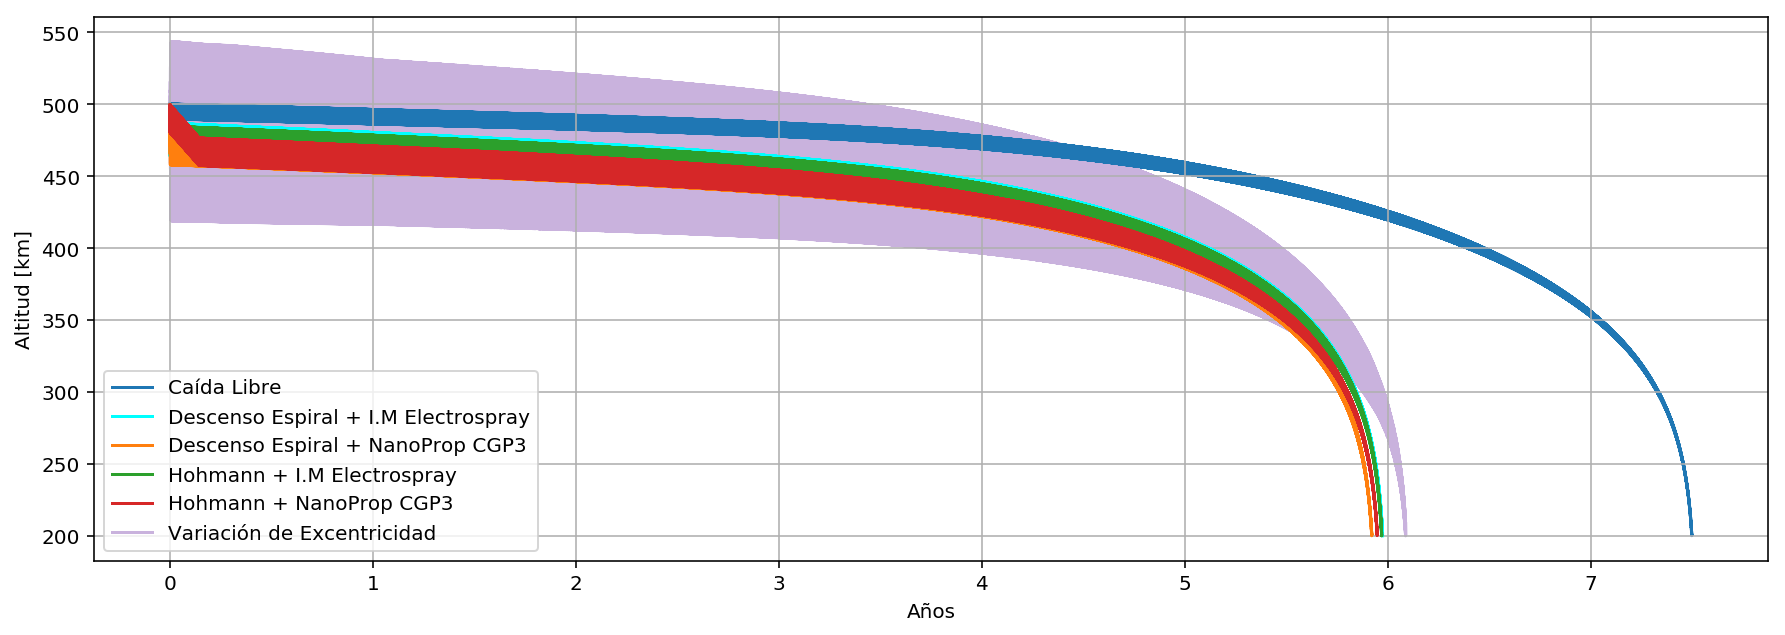

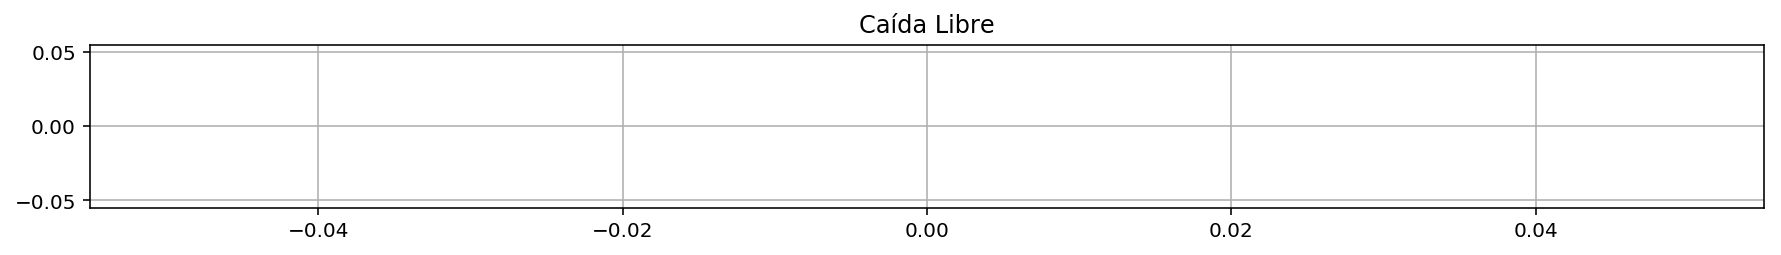

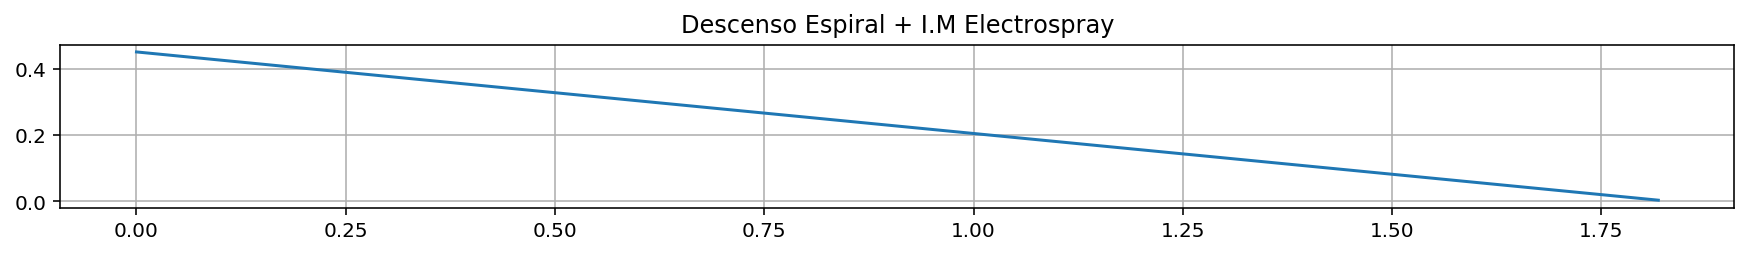

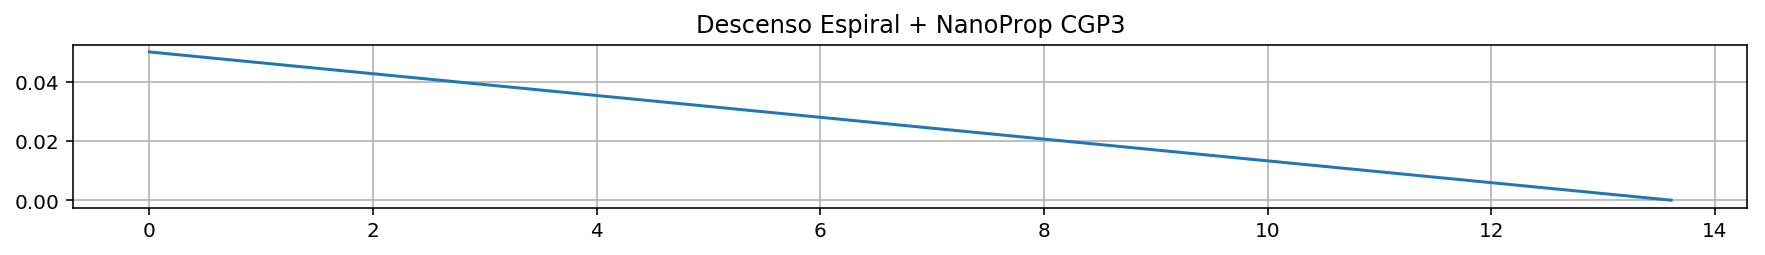

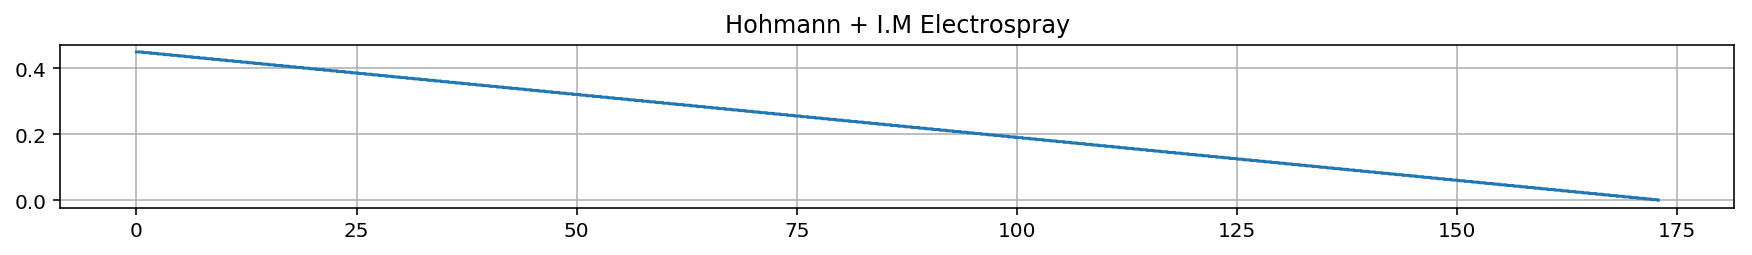

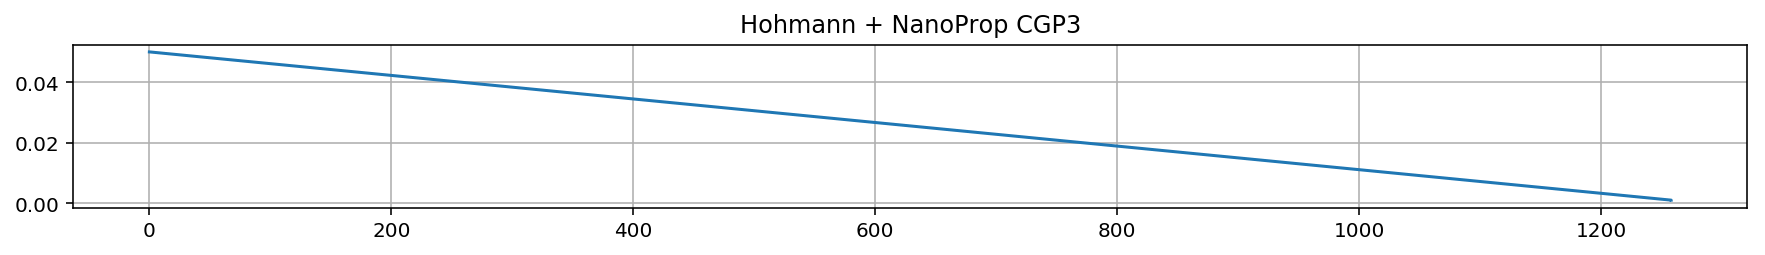

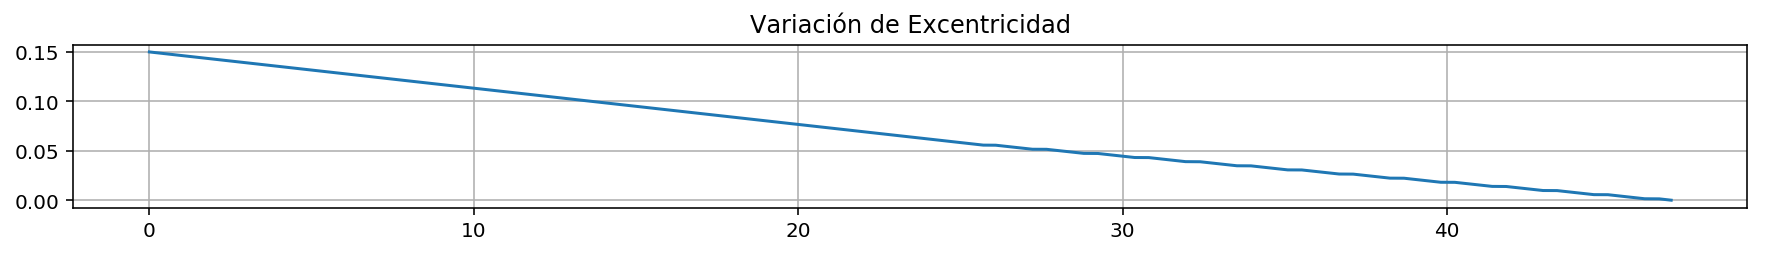

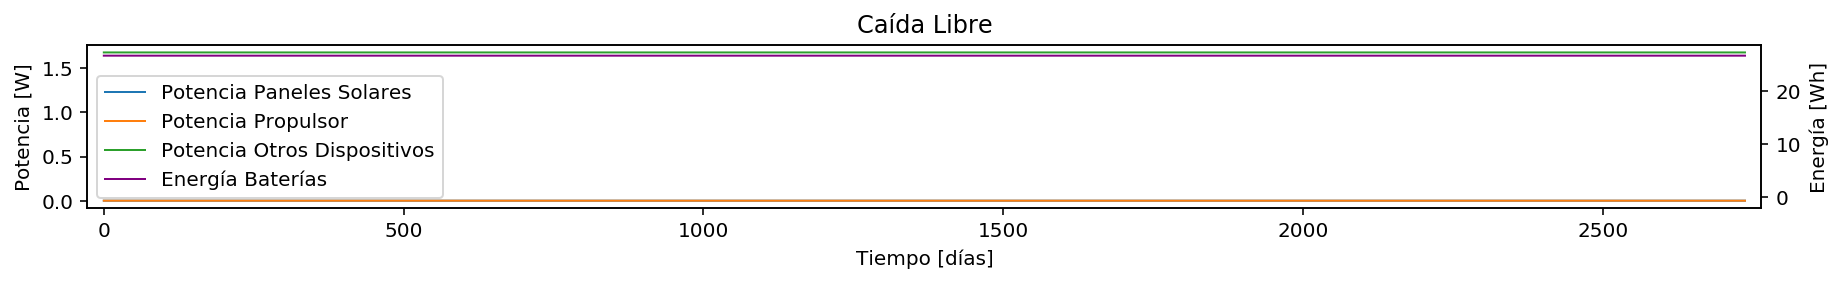

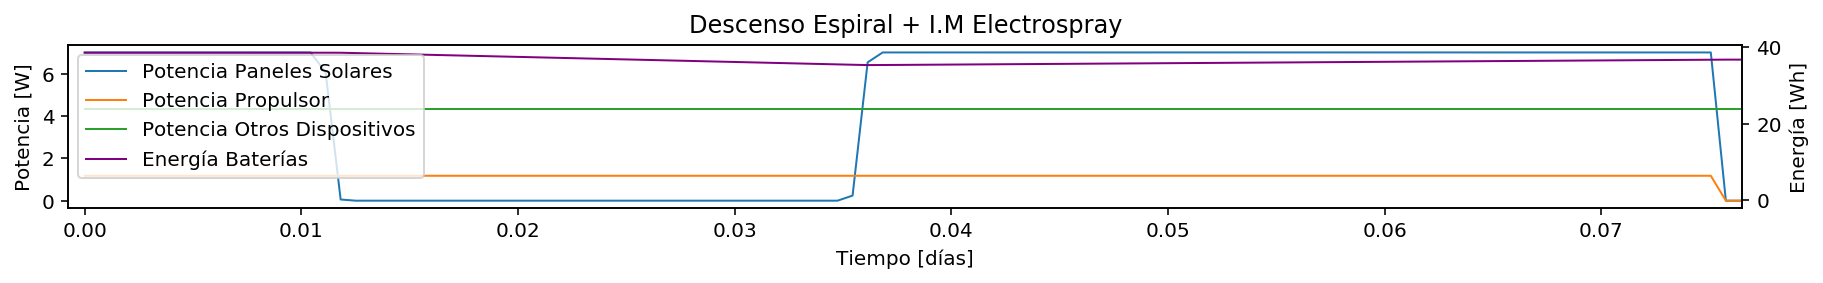

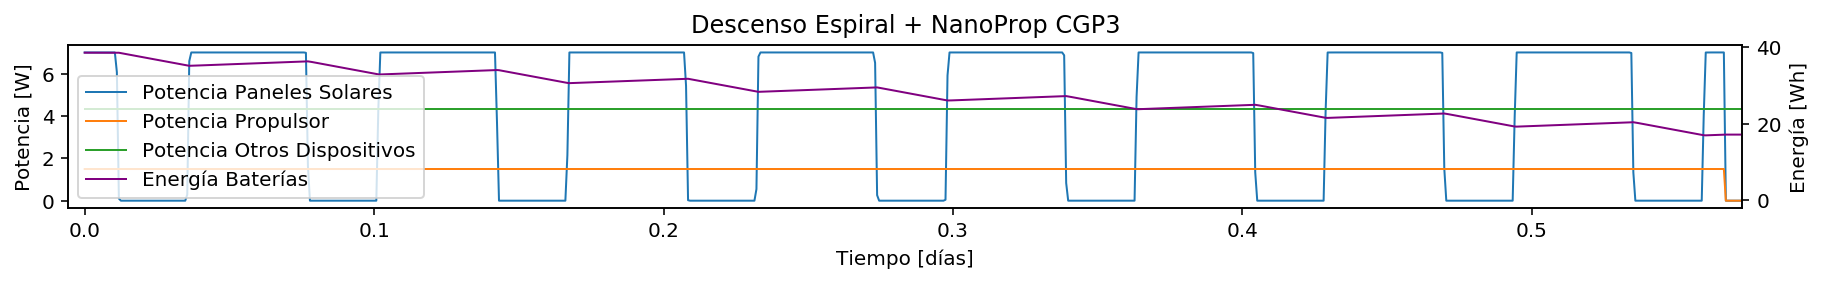

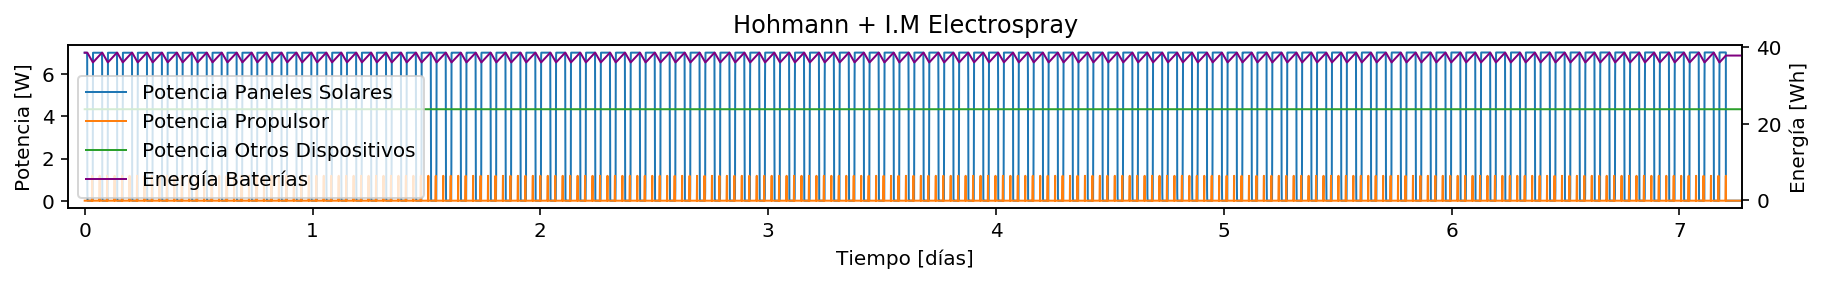

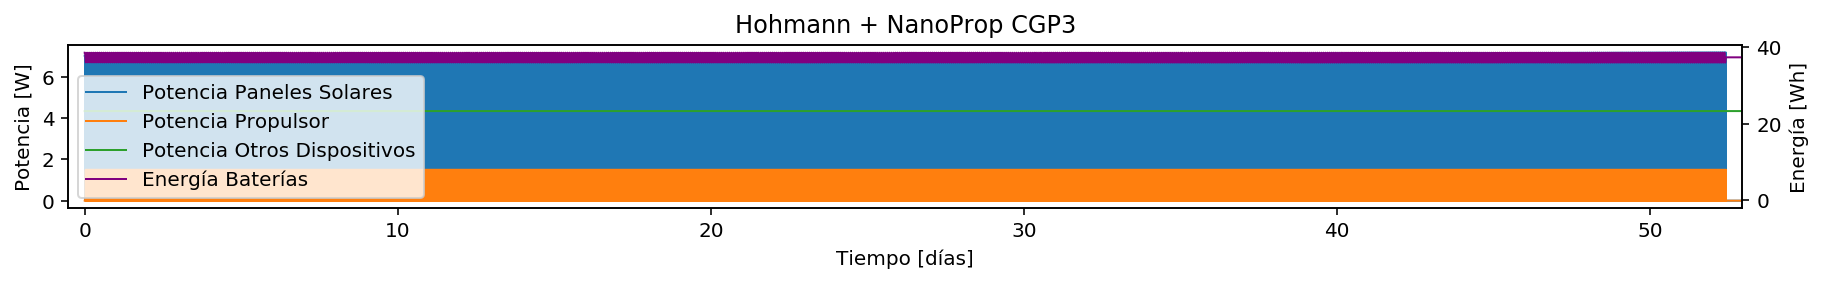

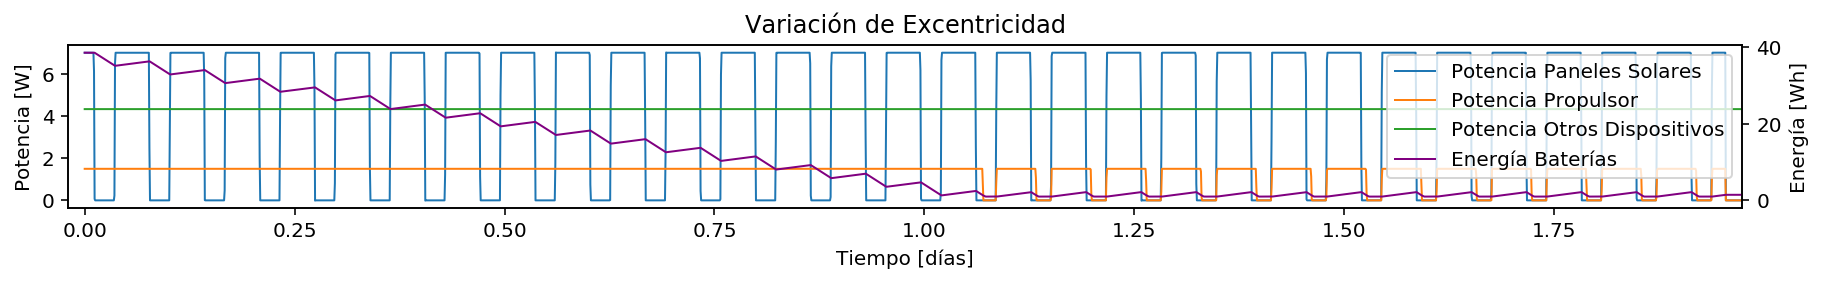

In [17]:
# RESULTS
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
scenarios2 = ["1","2.1","2.2","3.1","3.2","4.1"]
labels = ["Caída Libre", 
          "Descenso Espiral + I.M Electrospray",
          "Descenso Espiral + NanoProp CGP3",
          "Hohmann + I.M Electrospray",
          "Hohmann + NanoProp CGP3",
          "Variación de Excentricidad"]
zorder = [1,2,4,3,5,0]
plt.figure(figsize=(15,5))
for i,key in enumerate(scenarios2):
    if i == 1:
        plt.plot(scenarios[key].history.t/60/60/24/365,np.linalg.norm(scenarios[key].history.r,axis=1)/1e3-constants.Re/1e3,
             label=labels[i],alpha=1,zorder=zorder[i],color="cyan")
    elif i == 5:
        plt.plot(scenarios[key].history.t/60/60/24/365,np.linalg.norm(scenarios[key].history.r,axis=1)/1e3-constants.Re/1e3,
             label=labels[i],alpha=0.5,zorder=zorder[i])
    else:
        plt.plot(scenarios[key].history.t/60/60/24/365,np.linalg.norm(scenarios[key].history.r,axis=1)/1e3-constants.Re/1e3,
             label=labels[i],alpha=1,zorder=zorder[i])
plt.xlabel("Años")
plt.ylabel("Altitud [km]");
plt.legend()
plt.grid()
#plt.xlim([0,0.01])
for i,key in enumerate(scenarios2):
    plt.figure(figsize=(15,1.5))
    endIdx = scenarios[key].history.maneuverIdxs[-2]
    plt.plot(scenarios[key].history.t[0:endIdx]/60/60,scenarios[key].history.propMass[0:endIdx])
    plt.title(labels[i])
    plt.grid()
for i,key in enumerate(scenarios2):
    endIdx = scenarios[key].history.maneuverIdxs[-2]
    scenarios[key].plot("energyUsage")
    plt.xlim([-scenarios[key].history.t[endIdx-1]/60/60/24*0.01,scenarios[key].history.t[endIdx-1]/60/60/24*1.01])
    plt.title(labels[i])
    plt.grid()
    plt.gcf().set_size_inches(15,1.5)

# USSA 1976 Model

In [4]:
# Case 1: Free Fall
coe = [constants.Re+490e3,0.0014,0,0,0,np.pi]
# MANEUVERING
scenarios["5"] = Maneuvers(coe,cubesat3U,date,verbose=True)
scenarios["5"].addPerturbation("atmosphere")
T = 2*np.pi*(scenarios["5"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["5"].propagate(60*60*24*365*20,60*10,max_step=T/2)
%notify -m "Case 5: Free Fall"
#----------------------------------------------------
# Case 2.1: Spiral Descent, VikiThruster
# MANEUVERING
scenarios["6.1"] = Maneuvers(coe,cubesat3Uv,date,verbose=True)
scenarios["6.1"].addPerturbation("atmosphere")
scenarios["6.1"].addPerturbation("thrust")
scenarios["6.1"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    return np.arctan2(e*np.sin(nu),1+e*np.cos(nu))+np.pi
def betaCallback(coe):
    return 0
scenarios["6.1"].thrustProfile = (alphaCallback,betaCallback)
scenarios["6.1"].propagate(60*60*24,60,max_step=10)

scenarios["6.1"].removePerturbation("thrust")
scenarios["6.1"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["6.1"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["6.1"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 6.1: Spiral Descent, VikiThruster"
#----------------------------------------------------
# Case 2.2: Spiral Descent, Commercial Thruster
# MANEUVERING
scenarios["6.2"] = Maneuvers(coe,cubesat3Uc,date,verbose=True)
scenarios["6.2"].addPerturbation("atmosphere")
scenarios["6.2"].addPerturbation("thrust")
scenarios["6.2"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    return np.arctan2(e*np.sin(nu),1+e*np.cos(nu))+np.pi
def betaCallback(coe):
    return 0
scenarios["6.2"].thrustProfile = (alphaCallback,betaCallback)
scenarios["6.2"].propagate(60*60*24,60,max_step=10)

scenarios["6.2"].removePerturbation("thrust")
scenarios["6.2"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["6.2"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["6.2"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 6.2: Spiral Descent, Commercial Thruster"

#----------------------------------------------------
# 4.1 Hohmann-style Descent, VikiThruster
# MANEUVERING
scenarios["7.1"] = Maneuvers(coe,cubesat3Uv,date,verbose=True)
scenarios["7.1"].addPerturbation("atmosphere")
scenarios["7.1"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    return np.arctan2(e*np.sin(nu),1+e*np.cos(nu))+np.pi
def betaCallback(coe):
    return 0
# -- SCENARIO START --
# 30s Thrust Time
thrustTime = 30
# Initial Propagation
scenarios["7.1"].propagate(thrustTime/2,1)
while True:
    T = 2*np.pi*(scenarios["7.1"].history.coe[-1,0]**3/constants.mu_E)**0.5
    #Propagate to Apogee/Perigee - thrustTime/2 of previous thrust - thrustTime/2 of current thrust
    startTimeThrust = T/2-thrustTime
    scenarios["7.1"].propagate(startTimeThrust,60,max_step=10)
    # Thrust for <thrustTime>
    scenarios["7.1"].addPerturbation("thrust")
    scenarios["7.1"].thrustProfile = (alphaCallback,betaCallback)
    scenarios["7.1"].propagate(thrustTime,1,max_step=1)
    scenarios["7.1"].removePerturbation("thrust")
    #print(scenarios["7.1"].history.propMass[-1])
    if scenarios["7.1"].history.propMass[-1] < 1e-3:
        break;
scenarios["7.1"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["7.1"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["7.1"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 7.1: Hohmann-style Descent, VikiThruster"

#----------------------------------------------------
# 4.2 Hohmann-style Descent, Commercial Thruster
# MANEUVERING
scenarios["7.2"] = Maneuvers(coe,cubesat3Uc,date,verbose=True)
scenarios["7.2"].addPerturbation("atmosphere")
scenarios["7.2"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    return np.arctan2(e*np.sin(nu),1+e*np.cos(nu))+np.pi
def betaCallback(coe):
    return 0
# -- SCENARIO START --
# 30s Thrust Time
thrustTime = 30
# Initial Propagation
scenarios["7.2"].propagate(thrustTime/2,1)
while True:
    T = 2*np.pi*(scenarios["7.2"].history.coe[-1,0]**3/constants.mu_E)**0.5
    #Propagate to Apogee/Perigee - thrustTime/2 of previous thrust - thrustTime/2 of current thrust
    startTimeThrust = T/2-thrustTime
    scenarios["7.2"].propagate(startTimeThrust,60,max_step=10)
    # Thrust for <thrustTime>
    scenarios["7.2"].addPerturbation("thrust")
    scenarios["7.2"].thrustProfile = (alphaCallback,betaCallback)
    scenarios["7.2"].propagate(thrustTime,1,max_step=1)
    scenarios["7.2"].removePerturbation("thrust")
    #print(scenarios["4.2"].history.propMass[-1])
    if scenarios["7.2"].history.propMass[-1] < 1e-3:
        break;
scenarios["7.2"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["7.2"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["7.2"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 7.2: Hohmann-style Descent, Commercial Thruster"
#----------------------------------------------------
# Case 3: Eccentricity Variation Descent
# MANEUVERING
cubesat3Uc2 = models.Spacecraft(3.9,3.9-0.15,10e-2*10e-2)
cubesat3Uc2.thruster = models.NanoPropCGP3()
cubesat3Uc2.solarPanels = models.DHV_CS_10(3)
cubesat3Uc2.battery = models.NanoPowerBP4("2P-2S")
scenarios["8.1"] = Maneuvers(coe,cubesat3Uc2,date,verbose=True)
scenarios["8.1"].addPerturbation("atmosphere")
scenarios["8.1"].addPerturbation("thrust")
scenarios["8.1"]._INCLUDE_ENERGY_CALCULATION_ = True
def alphaCallback(coe):
    e = coe[1]
    nu = coe[5]
    E = 2*np.arctan2(np.tan(nu/2),np.sqrt((1+e)/(1-e)))
    return np.arctan2(np.sin(nu),np.cos(nu)+np.cos(E))
def betaCallback(coe):
    return 0
scenarios["8.1"].thrustProfile = (alphaCallback,betaCallback)
scenarios["8.1"].propagate(60*60*24*4,60,max_step=10)
scenarios["8.1"].removePerturbation("thrust")
scenarios["8.1"]._INCLUDE_ENERGY_CALCULATION_ = False
T = 2*np.pi*(scenarios["8.1"].history.coe[-1,0]**3/constants.mu_E)**0.5
scenarios["8.1"].propagate(60*60*24*365*10,60*10,max_step=T/2)
%notify -m "Case 8: Eccentricity Variation Descent"

Propagating...from day  0.0  to  7300.0
Day: 4228.000	Altitude: 206.406 km	Mass: 0.100
A termination event occurred. (Status Code: 1)
100.0%



<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  1.0
Day: 0.001	Altitude: 499.567 km	Mass: 0.444
A termination event occurred. (Status Code: 1)
100.0%

Propagating...from day  0.07574704656011119  to  3650.07574704656
Day: 2899.000	Altitude: 202.218 km	Mass: 0.004
A termination event occurred. (Status Code: 1)
100.0%



<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  1.0
Day: 0.001	Altitude: 499.567 km	Mass: 0.050
A termination event occurred. (Status Code: 1)
100.0%

Propagating...from day  0.5670604586518416  to  3650.5670604586517
Day: 2807.000	Altitude: 204.599 km	Mass: 0.000
A termination event occurred. (Status Code: 1)
100.0%



<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  0.00017361111111111112
Day: 0.000	Altitude: 499.614 km	Mass: 0.450
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.00017361111111111112  to  0.032623189325597234
Day: 0.001	Altitude: 499.561 km	Mass: 0.450
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.032623189325597234  to  0.032970411547819455

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.032970411547819455  to  0.06541953202778197

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.06541953202778197  to  0.0657667542500042

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.0657667542500042  to  0.09821541803887888

The solver successfully reached 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9507471474730784  to  0.9510943696953006

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9510943696953006  to  0.9835305952045658

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9835305952045658  to  0.983877817426788

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.983877817426788  to  1.0163135795766187
Day: 1.001	Altitude: 487.139 km	Mass: 0.389
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.0163135795766187  to  1.0166608017988408

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.0166608017988408  to  1.0490

Propagating...from day  1.8685074983529075  to  1.8688547205751298

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8688547205751298  to  1.9012778613733332

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.9012778613733332  to  1.9016250835955555

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.9016250835955555  to  1.9340477541615846

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.9340477541615846  to  1.934394976383807

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.934394976383807  to  1.9668171751472963

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.9668


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.720383252202056  to  2.7207304744242786

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.7207304744242786  to  2.7531412901587733

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.7531412901587733  to  2.753488512380996

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.753488512380996  to  2.78589885131151

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.78589885131151  to  2.7862460735337327

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.7862460735337327  to  2.818655934064195

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.5719363967382116  to  3.572283618960434

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.572283618960434  to  3.604681936148029

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.604681936148029  to  3.6050291583702507

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.6050291583702507  to  3.6374269919907185

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.6374269919907185  to  3.637774214212941

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.637774214212941  to  3.670171562644043

The solver successfully reached th

100.0%

Propagating...from day  4.4231623583517665  to  4.423509580573988

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.423509580573988  to  4.45589522064891

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.45589522064891  to  4.456242442871132

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.456242442871132  to  4.488627592415951

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.488627592415951  to  4.488974814638173

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.488974814638173  to  4.521359472003314

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.5213594


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.274056428358561  to  5.2744036505807825

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.2744036505807825  to  5.306776429657998

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.306776429657998  to  5.307123651880221

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.307123651880221  to  5.339495933255574

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.339495933255574  to  5.339843155477795

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.339843155477795  to  5.3722149374732675

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.124613756812843  to  6.124960979035066

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.124960979035066  to  6.157320707670551

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.157320707670551  to  6.1576679298927735

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.1576679298927735  to  6.190027153435779

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.190027153435779  to  6.190374375658002

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.190374375658002  to  6.222733092401321

The solver successfully reached the e


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.974829345990315  to  6.975176568212537

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.975176568212537  to  7.00752305114175
Day: 7.001	Altitude: 483.274 km	Mass: 0.014
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.00752305114175  to  7.007870273363973

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.007870273363973  to  7.040216243581402

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.040216243581402  to  7.040563465803625

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.040563465803625  to  7.072908921571636

<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  0.00017361111111111112
Day: 0.000	Altitude: 499.614 km	Mass: 0.050
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.00017361111111111112  to  0.032623189325597234
Day: 0.001	Altitude: 499.561 km	Mass: 0.050
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.032623189325597234  to  0.032970411547819455

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.032970411547819455  to  0.06541988698828197

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.06541988698828197  to  0.06576710921050419

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.06576710921050419  to  0.09821648216542443

The solver successfully reache

100.0%

Propagating...from day  0.8200628288675381  to  0.852509840862564

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.852509840862564  to  0.8528570630847861

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.8528570630847861  to  0.88530397256832

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.88530397256832  to  0.8856511947905422

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.8856511947905422  to  0.9180980014686821

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.9180980014686821  to  0.9184452236909043

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  0.


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.770706717775034  to  1.7710539399972562

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.7710539399972562  to  1.8034979746005482

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8034979746005482  to  1.8038451968227707

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.8038451968227707  to  1.836289128588647

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.836289128588647  to  1.836636350810869

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  1.836636350810869  to  1.8690801800312897

The solver successfully reached 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.721611466983104  to  2.7219586892053265

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.7219586892053265  to  2.754399745161386

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.754399745161386  to  2.7547469673836087

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.7547469673836087  to  2.787187920762135

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.787187920762135  to  2.7875351429843573

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  2.7875351429843573  to  2.8199759934909867

The solver successfully reached 

100.0%

Propagating...from day  3.5744205354069902  to  3.606858920160926

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.606858920160926  to  3.6072061423831485

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.6072061423831485  to  3.6396444245296244

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.6396444245296244  to  3.639991646751847

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.639991646751847  to  3.6724298259963972

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  3.6724298259963972  to  3.6727770482186197

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.426812920598425  to  4.45924863336954

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.45924863336954  to  4.459595855591762

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.459595855591762  to  4.492031465725336

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.492031465725336  to  4.492378687947558

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.492378687947558  to  4.524814195149332

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  4.524814195149332  to  4.525161417371555

The solver successfully reached the end o


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.278788602256242  to  5.279135824478464

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.279135824478464  to  5.311568864485353

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.311568864485353  to  5.3119160867075745

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.3119160867075745  to  5.3443490240467

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.3443490240467  to  5.344696246268923

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  5.344696246268923  to  5.3771290806459815

The solver successfully reached the end 

Propagating...from day  6.098264312759742  to  6.098611534981964

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.098611534981964  to  6.131042004426855

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.131042004426855  to  6.131389226649078

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.131389226649078  to  6.163819593103835

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.163819593103835  to  6.164166815326056

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.164166815326056  to  6.196597079082694

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.19659707908269


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.950798089220907  to  6.98322588435255

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.98322588435255  to  6.983573106574773

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  6.983573106574773  to  7.016000798685739
Day: 7.001	Altitude: 488.114 km	Mass: 0.043
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.016000798685739  to  7.016348020907962

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.016348020907962  to  7.04877561029031

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.04877561029031  to  7.0491228325125315



The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.802567879161681  to  7.802915101383903

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.802915101383903  to  7.835340221407141

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.835340221407141  to  7.835687443629364

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.835687443629364  to  7.86811246060124

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.86811246060124  to  7.868459682823463

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  7.868459682823463  to  7.9008845970360895

The solver successfully reached the end 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.654615328531177  to  8.6549625507534

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.6549625507534  to  8.68738499486961

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.68738499486961  to  8.687732217091833

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.687732217091833  to  8.720154558125875

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.720154558125875  to  8.720501780348098

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  8.720501780348098  to  8.75292401859212

The solver successfully reached the end of the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.506593194296455  to  9.506940416518677

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.506940416518677  to  9.539360183925522

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.539360183925522  to  9.539707406147743

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.539707406147743  to  9.572127070441464

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.572127070441464  to  9.572474292663687

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  9.572474292663687  to  9.604893854136472

The solver successfully reached the end


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.358501455549641  to  10.358848677771862

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.358848677771862  to  10.391265767663265

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.391265767663265  to  10.391612989885486

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.391612989885486  to  10.424029976632685

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.424029976632685  to  10.424377198854907

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  10.424377198854907  to  10.45679408275012

The solver successfully reac


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.210340091288955  to  11.210687313511178

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.210687313511178  to  11.243101725077551

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.243101725077551  to  11.243448947299774

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.243448947299774  to  11.27586325569068

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.27586325569068  to  11.276210477912903

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  11.276210477912903  to  11.308624683420623

The solver successfully reach


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.06210908041767  to  12.062456302639893

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.062456302639893  to  12.094868035067853

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.094868035067853  to  12.095215257290073

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.095215257290073  to  12.127626886511182

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.127626886511182  to  12.127974108733406

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.127974108733406  to  12.160385635039992

The solver successfully reac


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.913808401742022  to  12.914155623964243

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.914155623964243  to  12.946564676436678

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.946564676436678  to  12.946911898658898

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.946911898658898  to  12.979320847892952

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.979320847892952  to  12.979668070115174

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  12.979668070115174  to  13.012076916403226
Day: 13.001	Altitude: 479.73


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.765438033969758  to  13.76578525619198

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.76578525619198  to  13.798191627887988

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.798191627887988  to  13.79853885011021

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.79853885011021  to  13.830945118536171

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.830945118536171  to  13.831292340758395

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  13.831292340758395  to  13.863698506206722

The solver successfully reached


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.616997955709067  to  14.617345177931291

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.617345177931291  to  14.649748868026144

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.649748868026144  to  14.650096090248367

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.650096090248367  to  14.68249967704138

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.68249967704138  to  14.682846899263602

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  14.682846899263602  to  14.715250383047213

The solver successfully reach


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.468488145471468  to  15.468835367693691

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.468835367693691  to  15.501236375358973

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.501236375358973  to  15.501583597581195

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.501583597581195  to  15.533984501912633

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.533984501912633  to  15.534331724134853

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  15.534331724134853  to  15.566732525424955

The solver successfully rea


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.319908581666308  to  16.320255803888532

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.320255803888532  to  16.35265412829177

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.35265412829177  to  16.353001350513996

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.353001350513996  to  16.385399571551286

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.385399571551286  to  16.38574679377351

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  16.38574679377351  to  16.418144911737397

The solver successfully reached


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.17125924260446  to  17.17160646482668

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.17160646482668  to  17.204002105131753

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.204002105131753  to  17.204349327353977

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.204349327353977  to  17.236744864260814

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.236744864260814  to  17.237092086483038

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  17.237092086483038  to  17.26948752028426

The solver successfully reached

Day: 18.001	Altitude: 477.531 km	Mass: 0.033
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.022540106495587  to  18.022887328717808

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.022887328717808  to  18.05528028408447

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.05528028408447  to  18.055627506306696

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.055627506306696  to  18.088020358242716

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.088020358242716  to  18.088367580464936

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.088367580464936  to  18.12


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.873751151446992  to  18.874098373669216

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.874098373669216  to  18.906488643253496

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.906488643253496  to  18.906835865475717

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.906835865475717  to  18.939226031596792

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.939226031596792  to  18.939573253819017

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  18.939573253819017  to  18.971963316769575

The solver successfully rea


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.72489235545541  to  19.72523957767763

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.72523957767763  to  19.75762716063004

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.75762716063004  to  19.757974382852264

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.757974382852264  to  19.79036186230876

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.79036186230876  to  19.79070908453098

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  19.79070908453098  to  19.823096460784303

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.57596369640337  to  20.576310918625595

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.576310918625595  to  20.608695814095707

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.608695814095707  to  20.60904303631793

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.60904303631793  to  20.64142782825922

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.64142782825922  to  20.641775050481446

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  20.641775050481446  to  20.674159739186745

The solver successfully reached 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.42696515212053  to  21.42731237434275

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.42731237434275  to  21.459694581474665

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.459694581474665  to  21.460041803696885

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.460041803696885  to  21.492423907266957

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.492423907266957  to  21.492771129489185

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  21.492771129489185  to  21.525153129790272

The solver successfully reache


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.27789670030249  to  22.278243922524712

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.278243922524712  to  22.310623440458304

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.310623440458304  to  22.31097066268053

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.31097066268053  to  22.343350077019092

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.343350077019092  to  22.343697299241313

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  22.343697299241313  to  22.37607661027776

The solver successfully reached


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.128758318534654  to  23.12910554075688

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.12910554075688  to  23.161482368628025

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.161482368628025  to  23.161829590850246

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.161829590850246  to  23.194206315093016

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.194206315093016  to  23.19455353731524

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.19455353731524  to  23.226930158222586

The solver successfully reached


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.979549984300647  to  23.979897206522867

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  23.979897206522867  to  24.01227134346352
Day: 24.001	Altitude: 475.068 km	Mass: 0.028
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.01227134346352  to  24.01261856568574

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.01261856568574  to  24.044992598964527

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.044992598964527  to  24.045339821186747

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.045339821186747  to  24.0777


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.830271674979176  to  24.8306188972014

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.8306188972014  to  24.862990342339213

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.862990342339213  to  24.863337564561434

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.863337564561434  to  24.895708906003758

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.895708906003758  to  24.89605612822598

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  24.89605612822598  to  24.928427366265833

The solver successfully reached t


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.680923367837067  to  25.681270590059288

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.681270590059288  to  25.71363934251787

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.71363934251787  to  25.713986564740093

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.713986564740093  to  25.74635521346933

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.74635521346933  to  25.74670243569155

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  25.74670243569155  to  25.779070980984542

The solver successfully reached t


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.531505040035427  to  26.531852262257647

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.531852262257647  to  26.564218321156407

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.564218321156407  to  26.56456554337863

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.56456554337863  to  26.596931498514035

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.596931498514035  to  26.597278720736256

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  26.597278720736256  to  26.62964457240149

The solver successfully reache


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.38201666862597  to  27.382363890848193

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.382363890848193  to  27.414727255302164

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.414727255302164  to  27.415074477524385

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.415074477524385  to  27.447437738180877

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.447437738180877  to  27.447784960403098

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  27.447784960403098  to  27.480148117555316

The solver successfully reac


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.2324582305492  to  28.23280545277142

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.23280545277142  to  28.265166121891735

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.265166121891735  to  28.265513344113955

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.265513344113955  to  28.297873909402465

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.297873909402465  to  28.298221131624686

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  28.298221131624686  to  28.330581593374678

The solver successfully reached


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.082829702640606  to  29.083176924862826

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.083176924862826  to  29.115534897756174

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.115534897756174  to  29.115882119978394

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.115882119978394  to  29.148239989005475

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.148239989005475  to  29.148587211227696

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.148587211227696  to  29.18094497668184

The solver successfully reac


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.933131061619154  to  29.933478283841378

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.933478283841378  to  29.96583355961012

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.96583355961012  to  29.966180781832346

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.966180781832346  to  29.998535953700184

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.998535953700184  to  29.998883175922405

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  29.998883175922405  to  30.031238244182713
Day: 30.001	Altitude: 486.116 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.783362284091947  to  30.783709506314167

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.783709506314167  to  30.816062084056316

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.816062084056316  to  30.816409306278544

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.816409306278544  to  30.84876178008499

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.84876178008499  to  30.849109002307213

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  30.849109002307213  to  30.881461372471364

The solver successfully reach


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.633523346554014  to  31.633870568776242

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.633870568776242  to  31.66622044758554

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.66622044758554  to  31.666567669807762

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.666567669807762  to  31.69891744464638

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.69891744464638  to  31.6992646668686

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  31.6992646668686  to  31.731614338030028

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.483614225387676  to  32.48396144760989

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.48396144760989  to  32.516308626575615

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.516308626575615  to  32.51665584879783

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.51665584879783  to  32.54900292375773

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.54900292375773  to  32.54935014597995

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  32.54935014597995  to  32.581697117227534

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.3336348968578  to  33.33398211908003

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.33398211908003  to  33.366326597287014

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.366326597287014  to  33.36667381950924

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.36667381950924  to  33.39901819367508

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.39901819367508  to  33.39936541589731

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  33.39936541589731  to  33.43170968631561

The solver successfully reached the en


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.18358533711594  to  34.18393255933817

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.18393255933817  to  34.216274335866885

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.216274335866885  to  34.21662155808911

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.21662155808911  to  34.2489632305412

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.2489632305412  to  34.24931045276342

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  34.24931045276342  to  34.281652021432514

The solver successfully reached the en

Day: 35.001	Altitude: 465.043 km	Mass: 0.017
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.033465522199656  to  35.03381274442189

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.03381274442189  to  35.0661518183484

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.0661518183484  to  35.066499040570626

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.066499040570626  to  35.09883801038483

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.09883801038483  to  35.09918523260705

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.09918523260705  to  35.1315240986


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.883275428025556  to  35.88362265024778

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.88362265024778  to  35.915959020643456

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.915959020643456  to  35.91630624286568

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.91630624286568  to  35.94864250911322

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.94864250911322  to  35.94898973133544

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  35.94898973133544  to  35.9813258937286

The solver successfully reached the e


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.7330150303977  to  36.733362252619926

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.733362252619926  to  36.765695918551764

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.765695918551764  to  36.76604314077399

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.76604314077399  to  36.798376702521686

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.798376702521686  to  36.7987239247439

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  36.7987239247439  to  36.83105738260128

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.58268430499881  to  37.58303152722103

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.58303152722103  to  37.61536248775139

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.61536248775139  to  37.615709709973615

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.615709709973615  to  37.64804056628365

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.64804056628365  to  37.648387788505865

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  37.648387788505865  to  37.68071854088946

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.43228322739272  to  38.43263044961495

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.43263044961495  to  38.46495870380151

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.46495870380151  to  38.46530592602373

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.46530592602373  to  38.4976340759536

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.4976340759536  to  38.49798129817582

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  38.49798129817582  to  38.53030934414294

The solver successfully reached the end o


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.28181177302233  to  39.28215899524455

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.28215899524455  to  39.3144845421405

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.3144845421405  to  39.31483176436272

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.31483176436272  to  39.347157206965434

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.347157206965434  to  39.34750442918766

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  39.34750442918766  to  39.37982976779113

The solver successfully reached the end


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.131269917210815  to  40.13161713943304

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.13161713943304  to  40.16393997808675

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.16393997808675  to  40.164287200308976

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.164287200308976  to  40.19660993463271

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.19660993463271  to  40.196957156854936

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.196957156854936  to  40.22927978714278

The solver successfully reached th


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.98065763515683  to  40.981004857379055

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  40.981004857379055  to  41.013324986834284
Day: 41.001	Altitude: 468.382 km	Mass: 0.012
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.013324986834284  to  41.01367220905651

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.01367220905651  to  41.045992234144904

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.045992234144904  to  41.04633945636713

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.04633945636713  to  41.07865


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.829974901915186  to  41.83032212413741

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.83032212413741  to  41.86263954343065

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.86263954343065  to  41.86298676565288

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.86298676565288  to  41.89530408054215

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.89530408054215  to  41.89565130276437

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  41.89565130276437  to  41.927968513543625

The solver successfully reached the e


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.67922169239074  to  42.679568914612965

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.679568914612965  to  42.711883622778196

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.711883622778196  to  42.71223084500041

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.71223084500041  to  42.7445454487244

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.7445454487244  to  42.74489267094662

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  42.74489267094662  to  42.77720717052336

The solver successfully reached the e


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.52839798141627  to  43.52874520363849

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.52874520363849  to  43.561057199705175

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.561057199705175  to  43.56140442192739

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.56140442192739  to  43.59371631351538

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.59371631351538  to  43.5940635357376

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  43.5940635357376  to  43.626375323140984

The solver successfully reached the en


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.3775037436996  to  44.37785096592182

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.37785096592182  to  44.41016024891474

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.41016024891474  to  44.41050747113696

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.41050747113696  to  44.44281664961357

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.44281664961357  to  44.44316387183579

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  44.44316387183579  to  44.475472946090186

The solver successfully reached the end


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.226538953823415  to  45.22688617604563

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.22688617604563  to  45.259192744984546

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.259192744984546  to  45.25953996720677

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.25953996720677  to  45.2918464315915

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.2918464315915  to  45.29219365381372

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  45.29219365381372  to  45.3245000139385

The solver successfully reached the end


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.07550358621481  to  46.075850808437025

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.075850808437025  to  46.108154662335295

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.108154662335295  to  46.10850188455752

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.10850188455752  to  46.14080563386356

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.14080563386356  to  46.14115285608579

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.14115285608579  to  46.173456501093916

The solver successfully reached th


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.924397615203844  to  46.92474483742607

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.92474483742607  to  46.957045975294875

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.957045975294875  to  46.95739319751709

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.95739319751709  to  46.989694230755454

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.989694230755454  to  46.99004145297767

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  46.99004145297767  to  47.02234238187997
Day: 47.001	Altitude: 473.698 km	Ma


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.77322101499606  to  47.77356823721828

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.77356823721828  to  47.80586665806237

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.80586665806237  to  47.806213880284595

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.806213880284595  to  47.838512196459796

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.838512196459796  to  47.83885941868203

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  47.83885941868203  to  47.87115763048285

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.621973759652754  to  48.62232098187497

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.62232098187497  to  48.654616684694076

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.654616684694076  to  48.654963906916294

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.654963906916294  to  48.6872595050279

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.6872595050279  to  48.68760672725012

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  48.68760672725012  to  48.719902220948796

The solver successfully reached the


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.47065582310549  to  49.471003045327706

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.471003045327706  to  49.50329602911662

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.50329602911662  to  49.50364325133884

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.50364325133884  to  49.53593613038145

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.53593613038145  to  49.536283352603675

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  49.536283352603675  to  49.568576127194625

The solver successfully reached th


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.31926717913323  to  50.31961440135546

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.31961440135546  to  50.351904665102474

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.351904665102474  to  50.35225188732469

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.35225188732469  to  50.38454204628638

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.38454204628638  to  50.384889268508594

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  50.384889268508594  to  50.4171793229797

The solver successfully reached the 


The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.16780780140629  to  51.168155023628515

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.168155023628515  to  51.20044256631923

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.20044256631923  to  51.20078978854145

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.20078978854145  to  51.23307722640764

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.23307722640764  to  51.233424448629854

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  51.233424448629854  to  51.265711781966324

The solver successfully reached th

Day: 52.001	Altitude: 467.890 km	Mass: 0.001
The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  52.01627766346909  to  52.01662488569131

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  52.01662488569131  to  52.048909706305174

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  52.048909706305174  to  52.04925692852739

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  52.04925692852739  to  52.0815416442773

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  52.0815416442773  to  52.081888866499526

The solver successfully reached the end of the integration interval. (Status Code: 0)
100.0%

Propagating...from day  52.081888866499526  to  52.114173477

<IPython.core.display.Javascript object>

Propagating...from day  0.0  to  4.0
Day: 1.001	Altitude: 487.037 km	Mass: 0.062
A termination event occurred. (Status Code: 1)
100.0%

Propagating...from day  1.9538114255947212  to  3651.953811425595
Day: 2967.000	Altitude: 243.085 km	Mass: 0.000
A termination event occurred. (Status Code: 1)
100.0%



<IPython.core.display.Javascript object>

{'5': <maneuvers.Maneuvers object at 0x000001E83C24E6A0>, '6.1': <maneuvers.Maneuvers object at 0x000001E839495358>, '6.2': <maneuvers.Maneuvers object at 0x000001E83BEE6320>, '7.1': <maneuvers.Maneuvers object at 0x000001E839748278>, '7.2': <maneuvers.Maneuvers object at 0x000001E83961C5C0>, '8.1': <maneuvers.Maneuvers object at 0x000001E83D4E9A58>, '1': <maneuvers.Maneuvers object at 0x000001E80E38CB70>, '2.1': <maneuvers.Maneuvers object at 0x000001E8008167F0>, '2.2': <maneuvers.Maneuvers object at 0x000001E80E077D30>, '3.1': <maneuvers.Maneuvers object at 0x000001E83C19D128>, '3.2': <maneuvers.Maneuvers object at 0x000001E844899D68>, '4.1': <maneuvers.Maneuvers object at 0x000001E83C19D710>}
0.0
1.9845961012078583
13.776117991409388
173.06232604896562
1257.963526678098
47.05814119803849


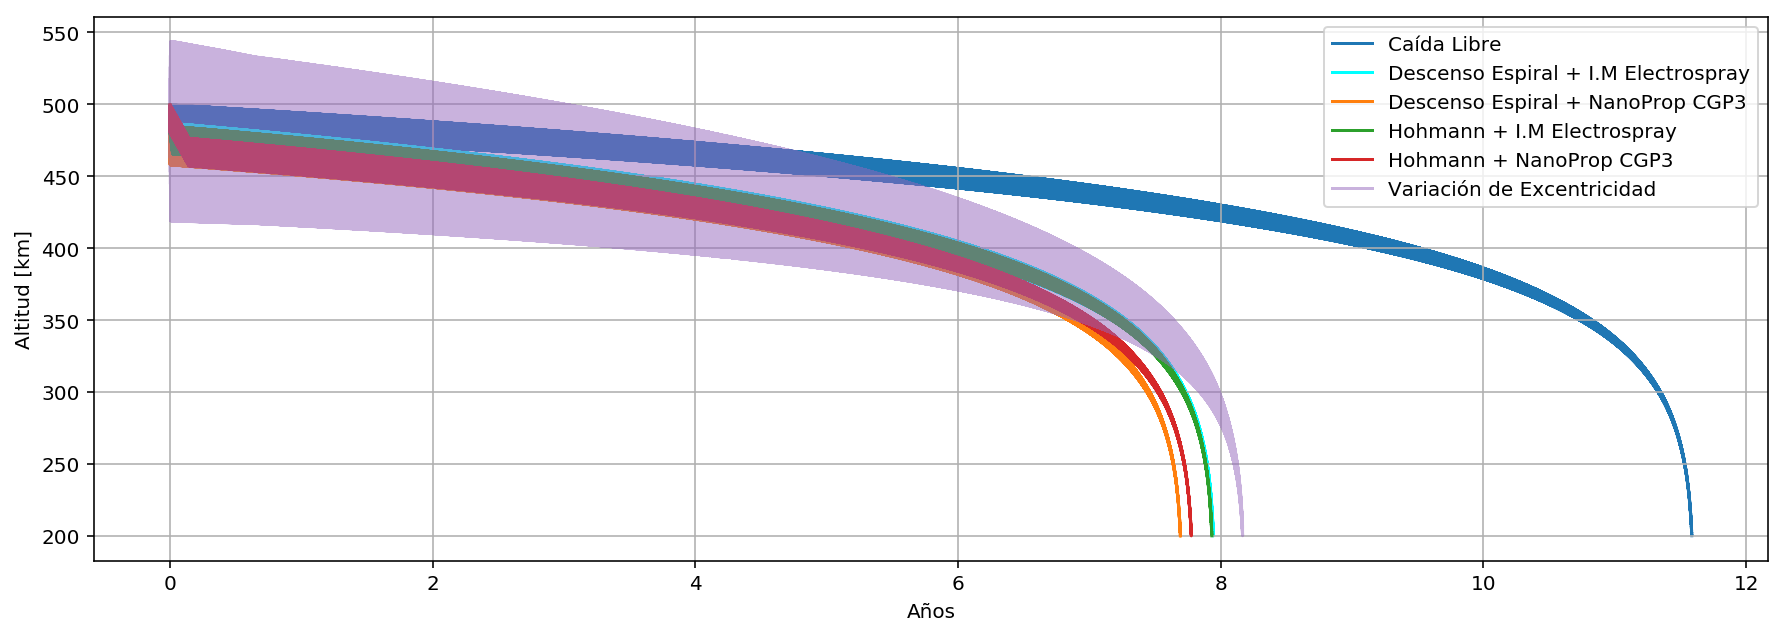

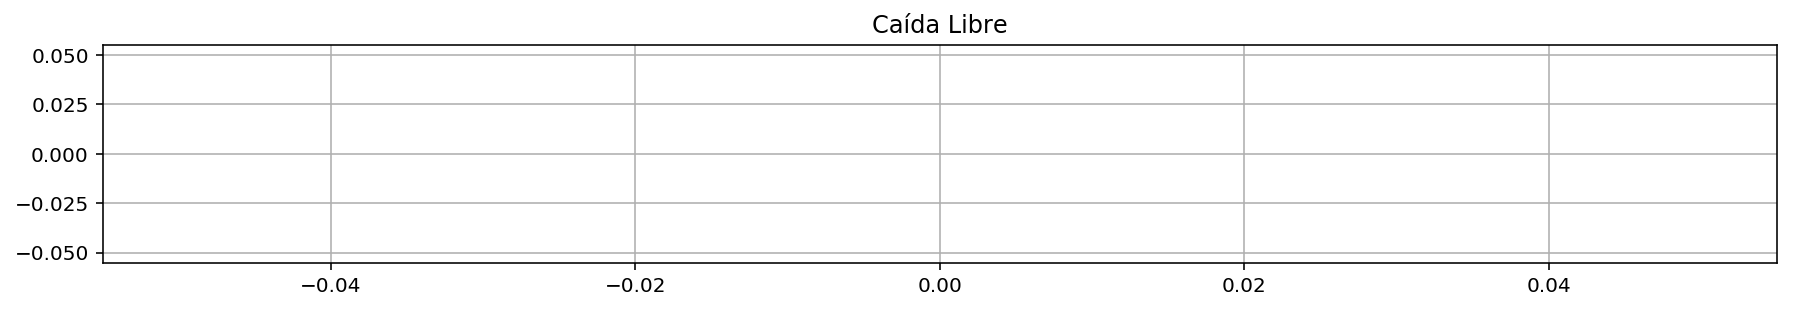

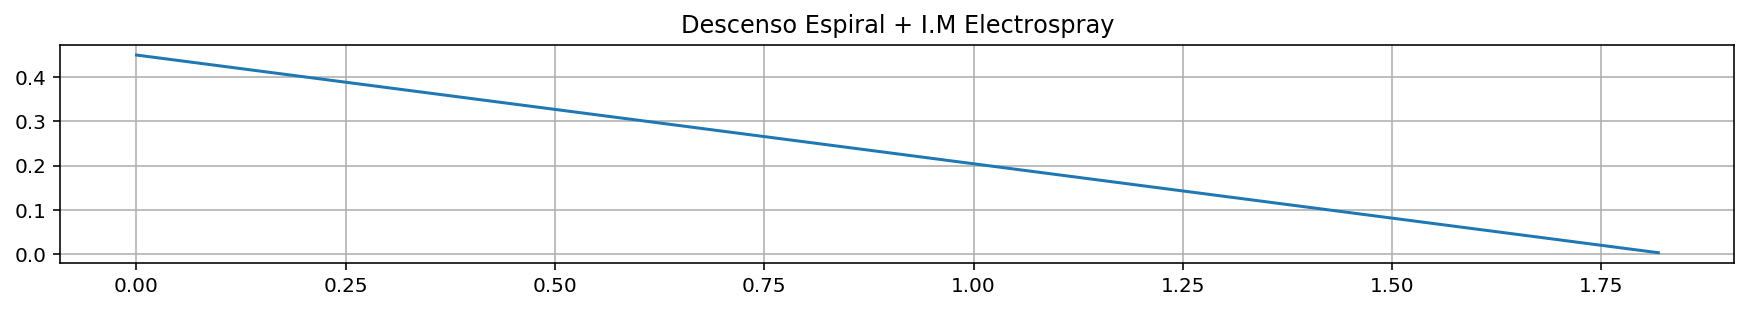

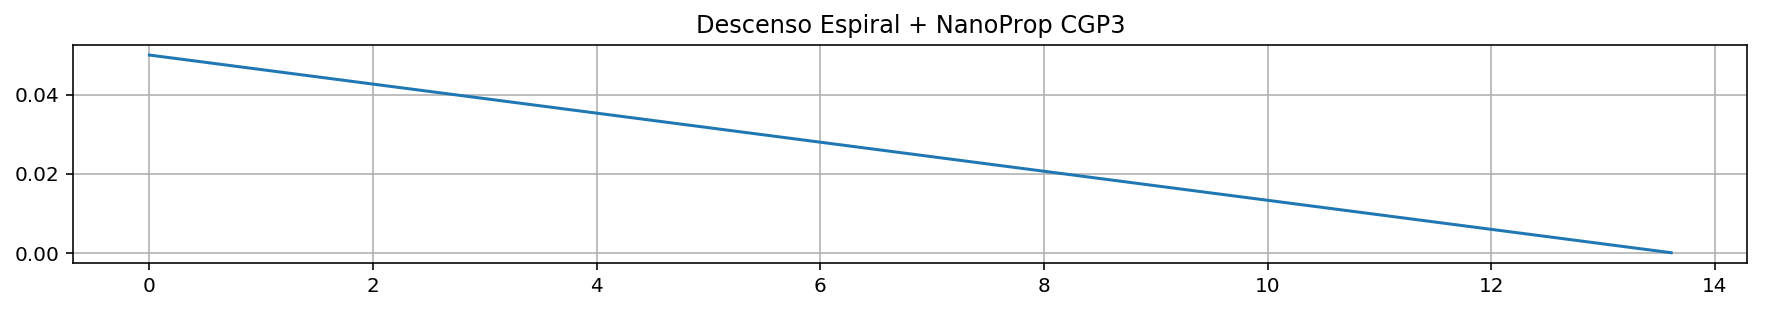

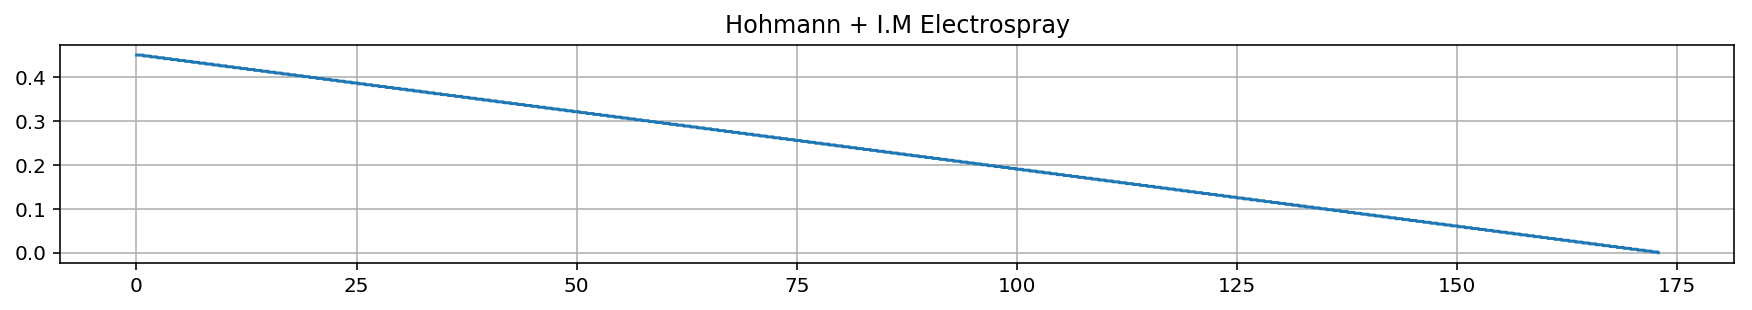

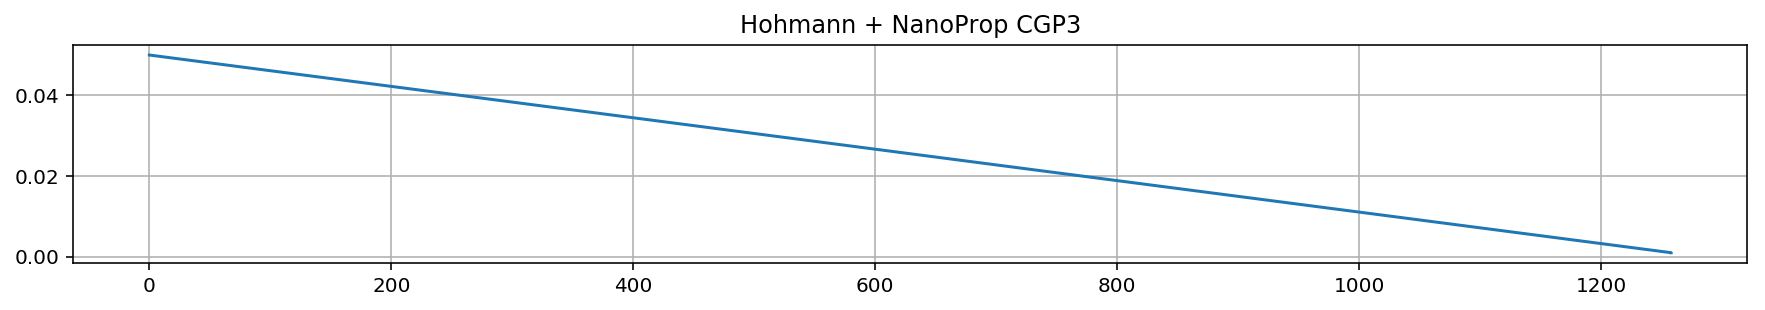

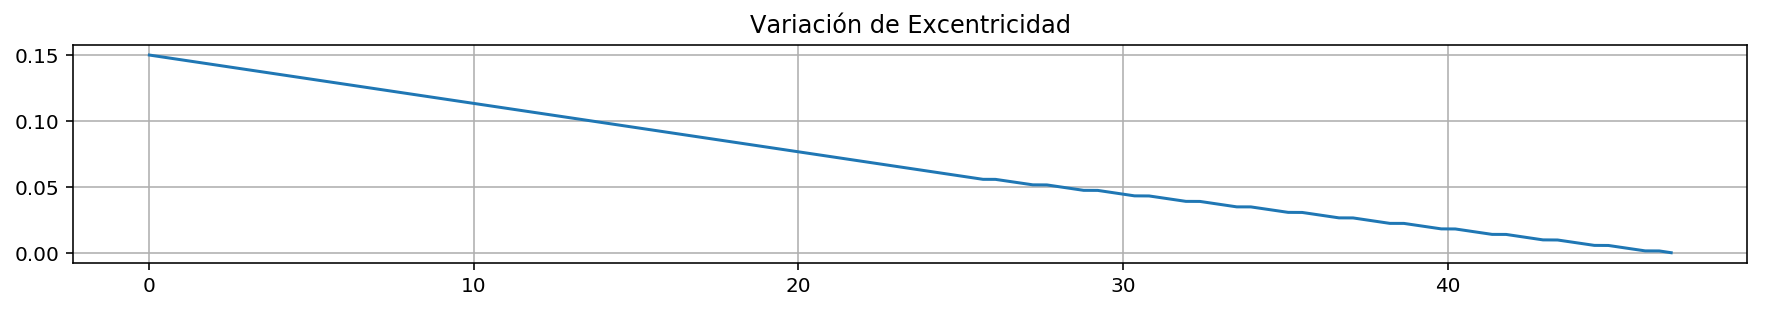

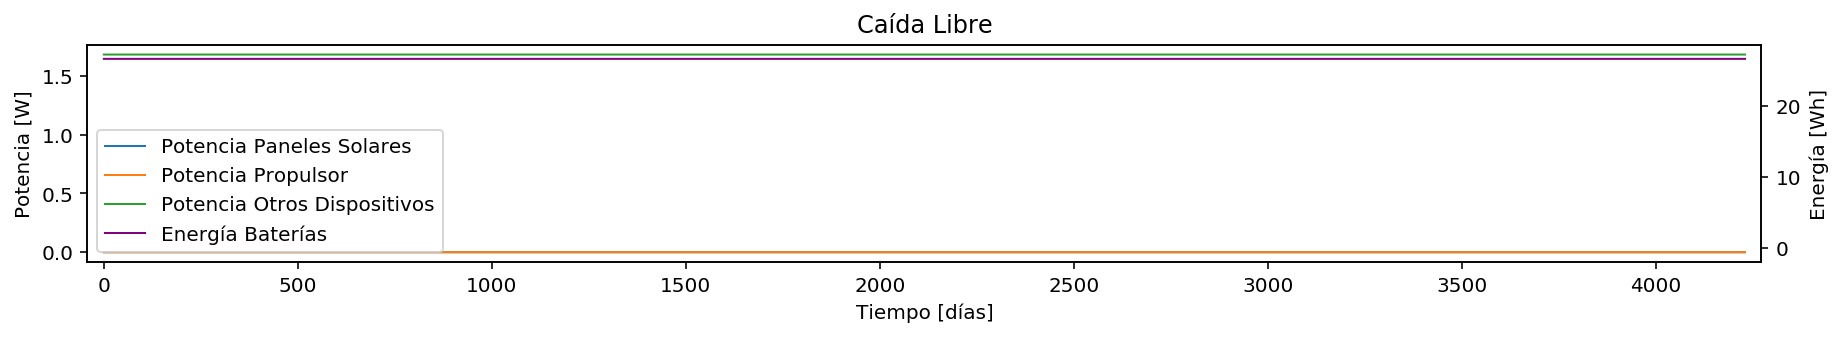

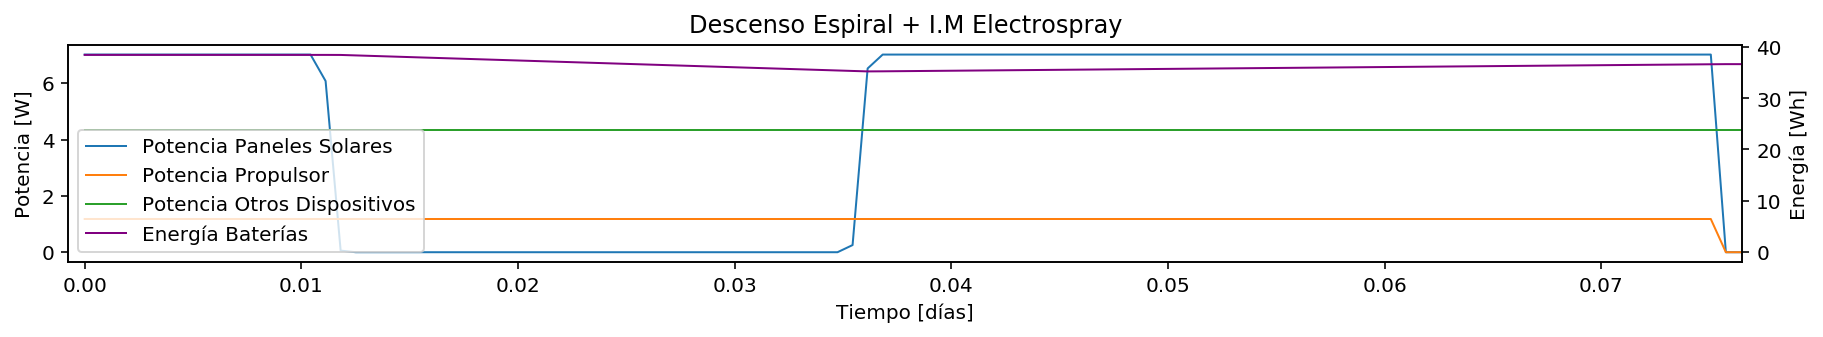

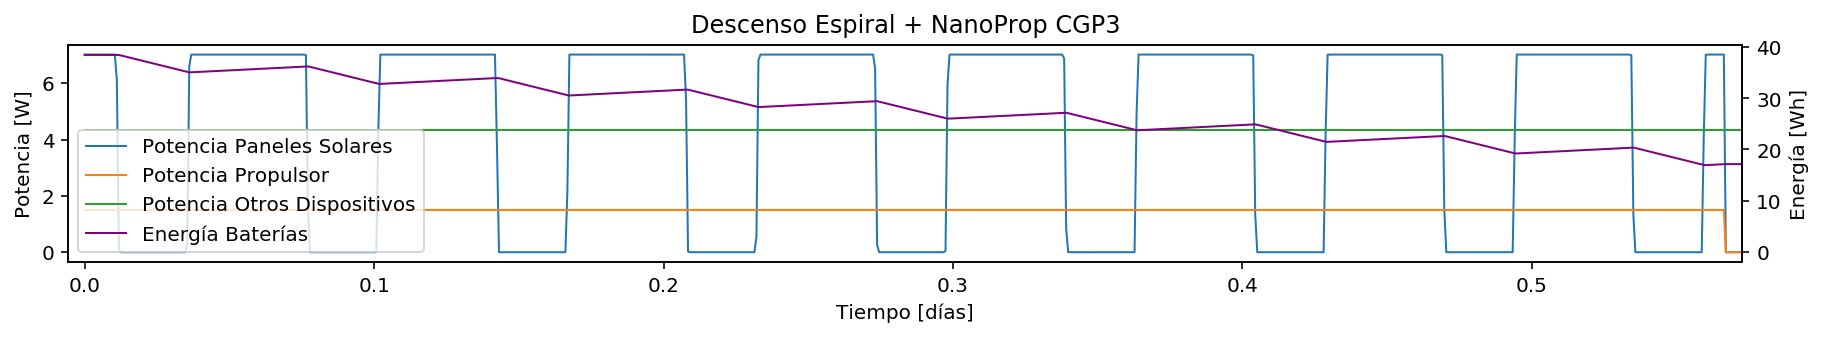

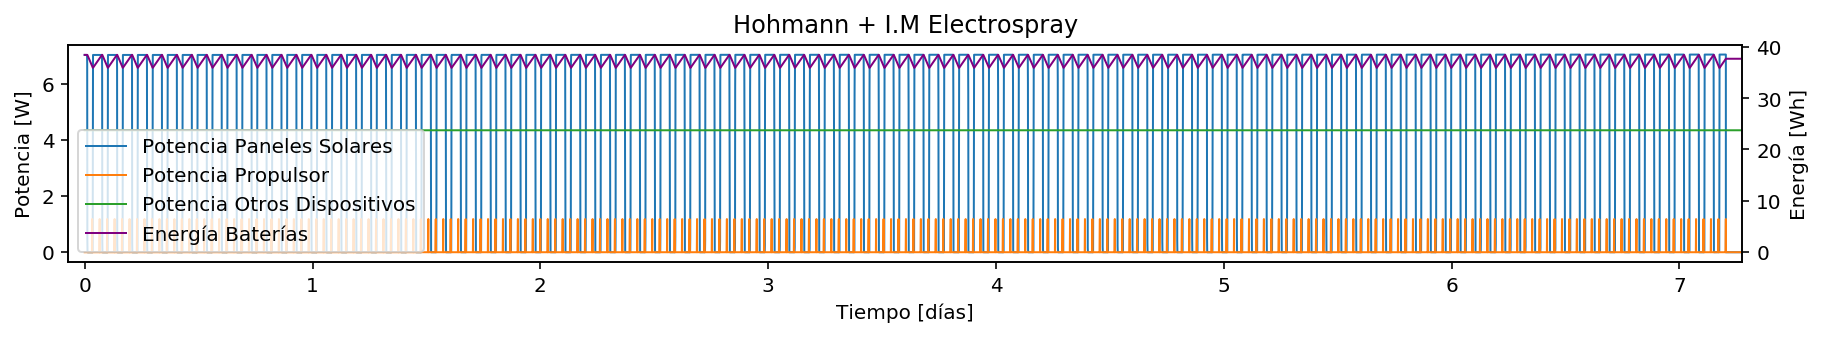

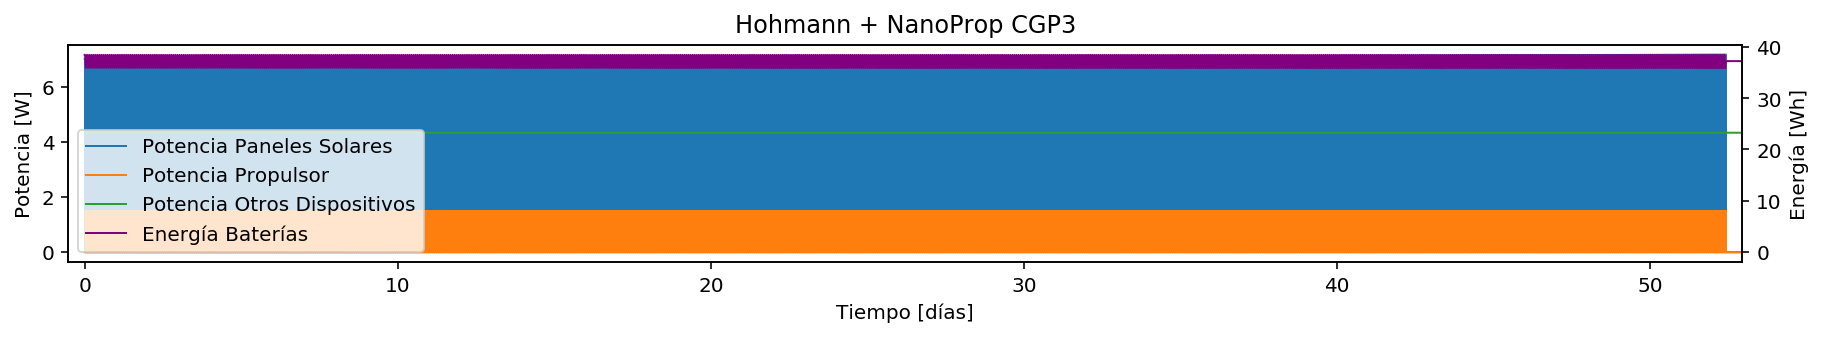

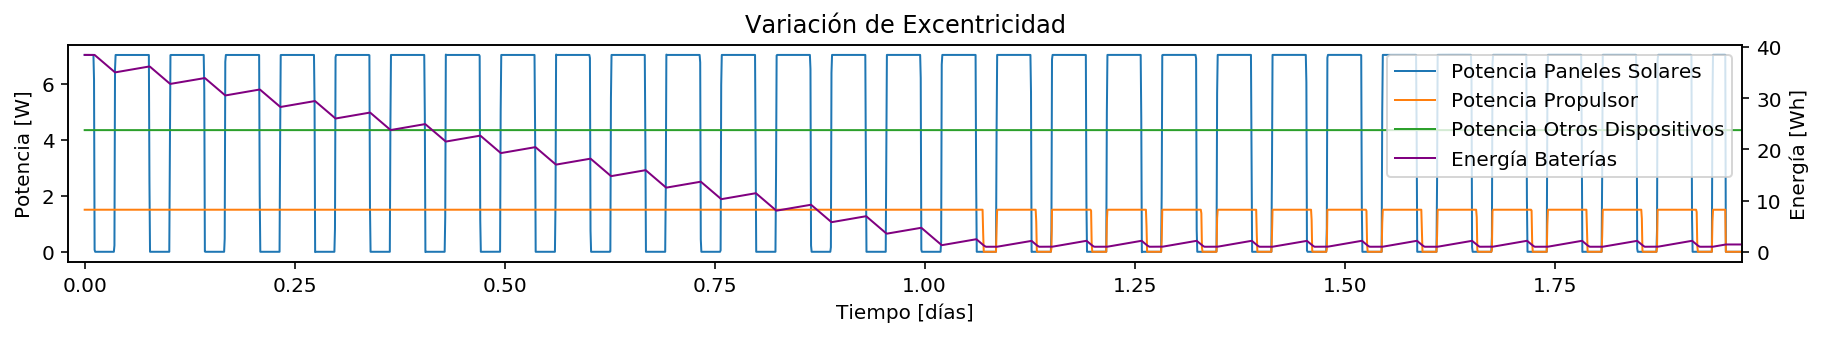

In [26]:
# RESULTS
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.figure(figsize=(15,5))
scenarios2 = ["5","6.1","6.2","7.1","7.2","8.1"]
labels = ["Caída Libre", 
          "Descenso Espiral + I.M Electrospray",
          "Descenso Espiral + NanoProp CGP3",
          "Hohmann + I.M Electrospray",
          "Hohmann + NanoProp CGP3",
          "Variación de Excentricidad"]
print(scenarios)
for i,key in enumerate(scenarios2):
    if i == 1:
        plt.plot(scenarios[key].history.t/60/60/24/365,np.linalg.norm(scenarios[key].history.r,axis=1)/1e3-constants.Re/1e3,
             label=labels[i],alpha=1,zorder=i,color="cyan")
    elif i == 5:
        plt.plot(scenarios[key].history.t/60/60/24/365,np.linalg.norm(scenarios[key].history.r,axis=1)/1e3-constants.Re/1e3,
             label=labels[i],alpha=0.5,zorder=i)
    else:
        plt.plot(scenarios[key].history.t/60/60/24/365,np.linalg.norm(scenarios[key].history.r,axis=1)/1e3-constants.Re/1e3,
             label=labels[i],alpha=1,zorder=i)
plt.xlabel("Años")
plt.ylabel("Altitud [km]");
plt.legend()
plt.grid()
for i,key in enumerate(scenarios2):
    plt.figure(figsize=(15,2))
    endIdx = scenarios[key].history.maneuverIdxs[-2]
    plt.plot(scenarios[key].history.t[0:endIdx]/60/60,scenarios[key].history.propMass[0:endIdx])
    plt.title(labels[i])
    plt.grid()
    print(scenarios[key].history.t[endIdx]/60/60)
for i,key in enumerate(scenarios2):
    endIdx = scenarios[key].history.maneuverIdxs[-2]
    scenarios[key].plot("energyUsage")
    plt.xlim([-scenarios[key].history.t[endIdx-1]/60/60/24*0.01,scenarios[key].history.t[endIdx-1]/60/60/24*1.01])
    plt.title(labels[i])
    plt.grid()
    plt.gcf().set_size_inches(15,2)

0.0
2.144065601111868
20.41417651146629
2.161216609195391
20.025
61.26296067193547
0.0
2.144065601111868
20.41417651146629
2.161216609195391
20.025
61.2812792534596


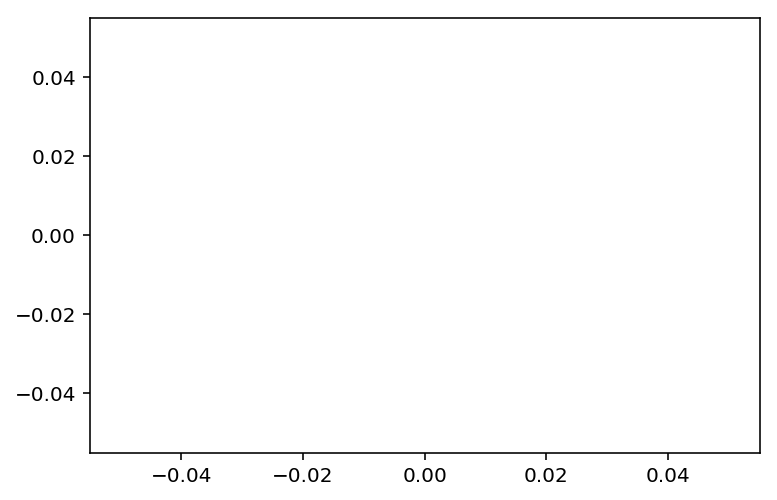

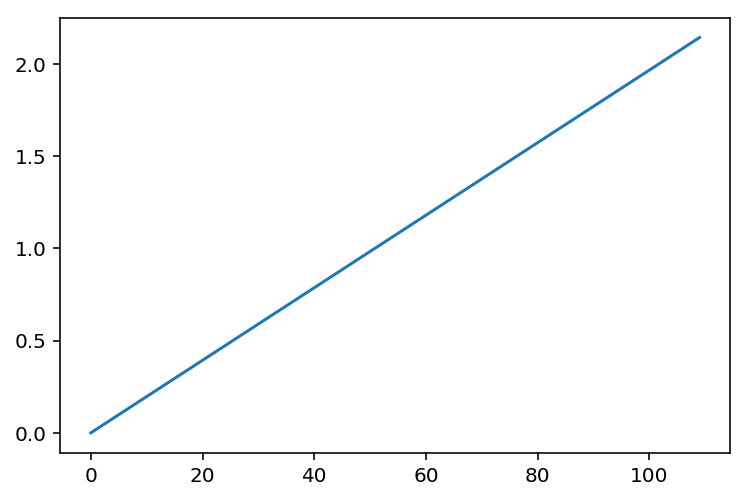

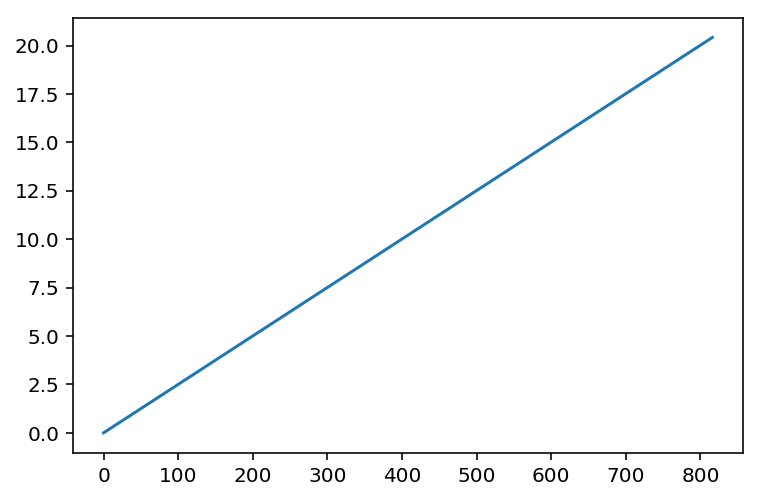

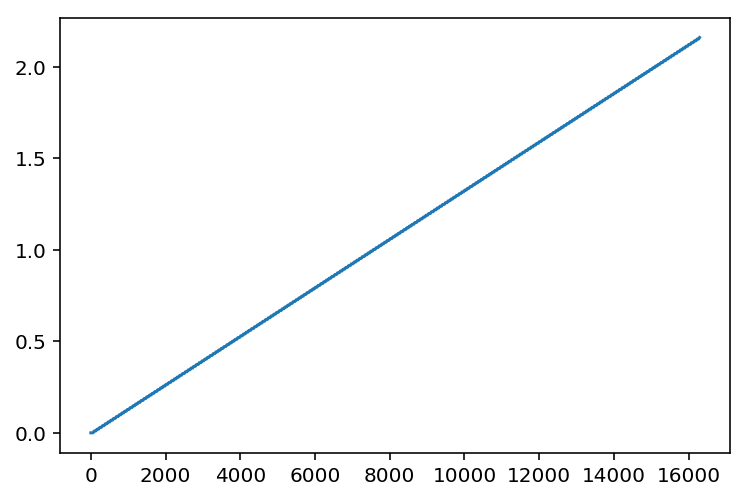

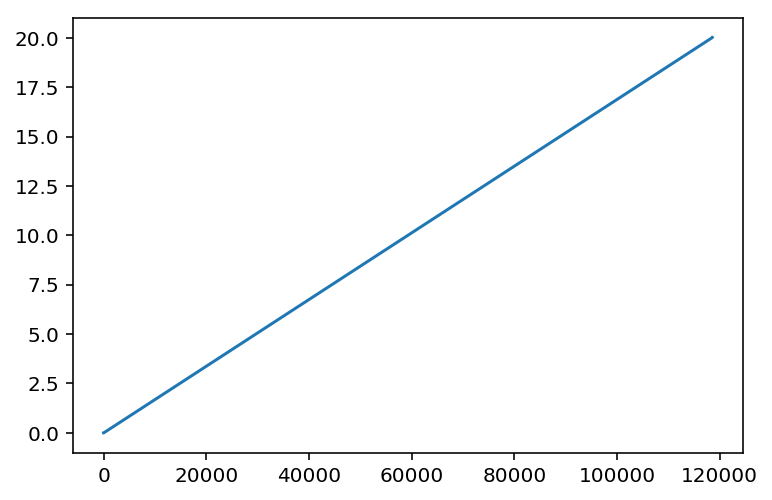

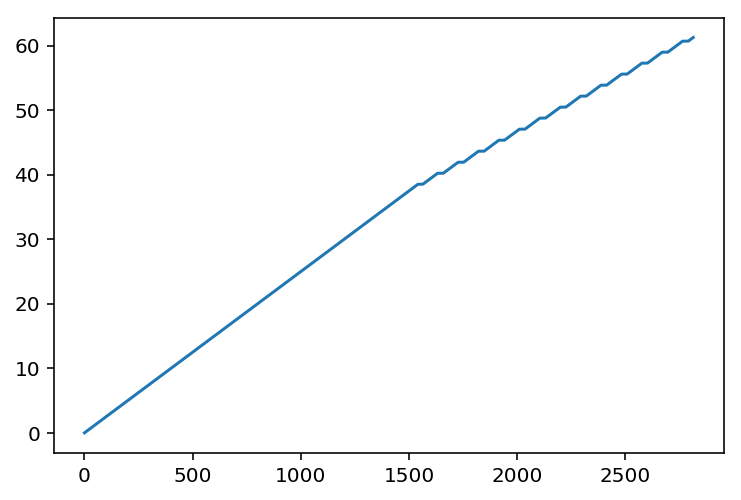

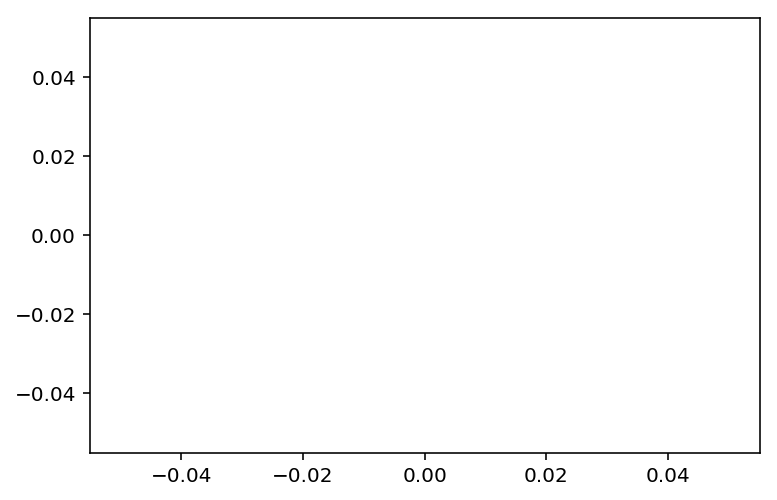

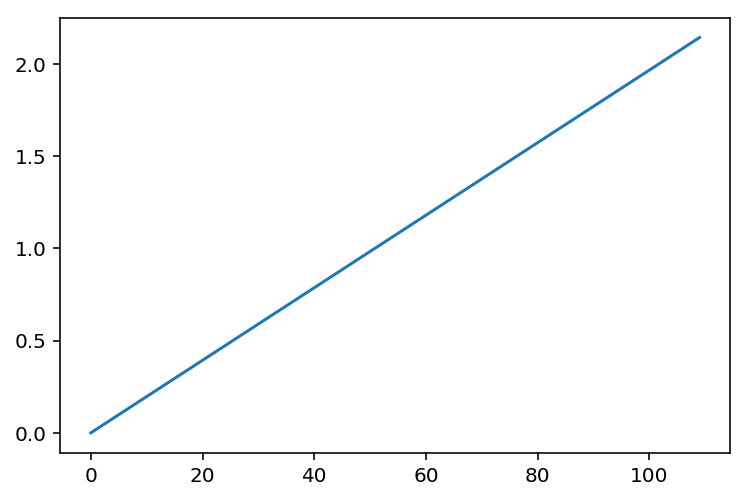

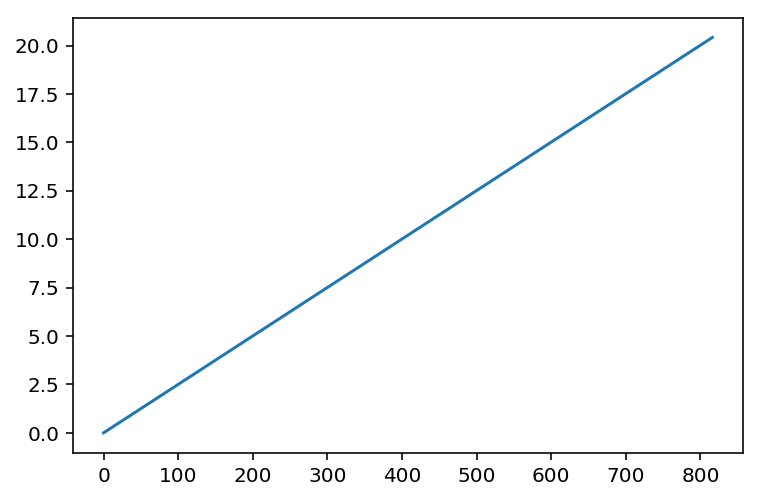

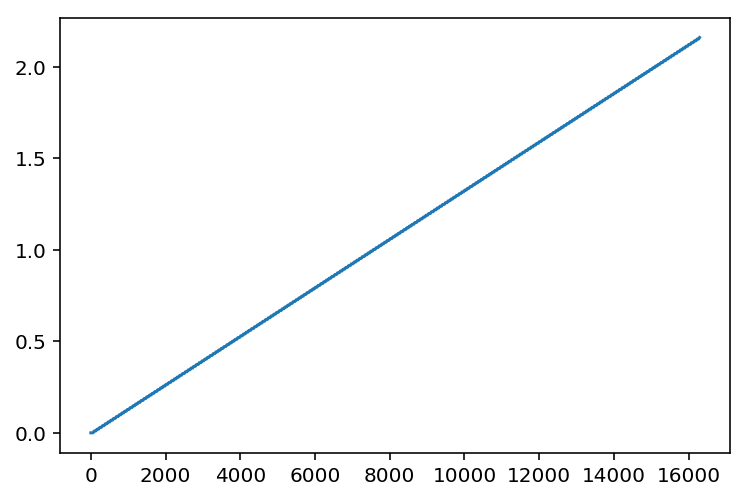

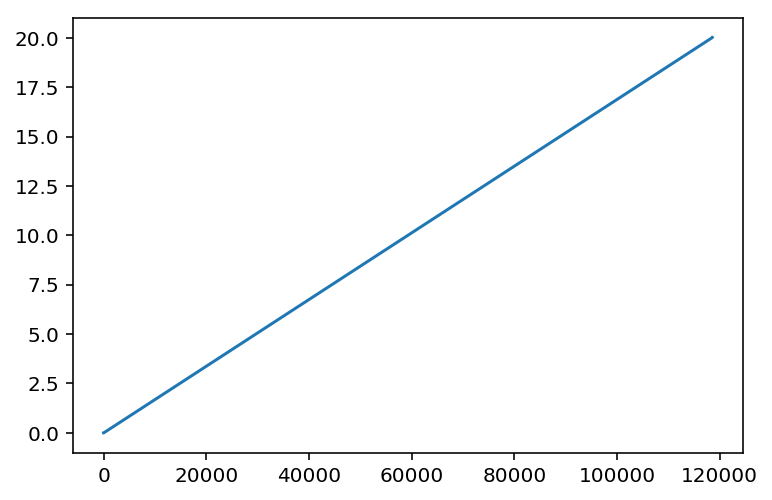

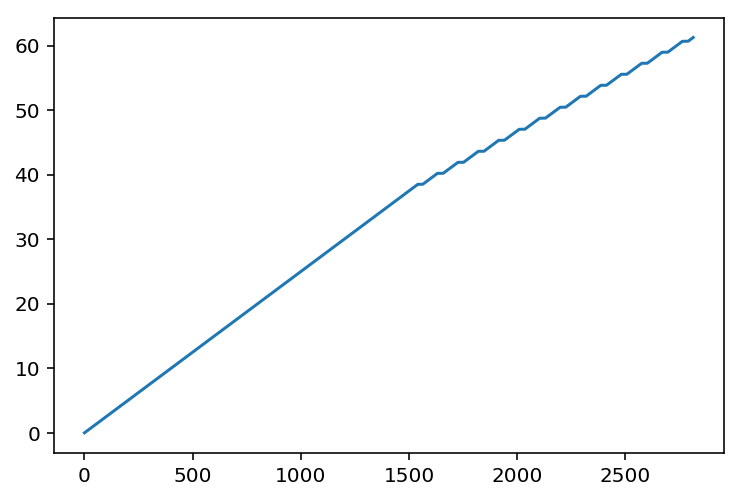

In [24]:
for key in scenarios:
    plt.figure()
    endIdx = scenarios[key].history.maneuverIdxs[-2]
    plt.plot(scenarios[key].history.energy["thruster"][0:endIdx]/60/60)
    print(scenarios[key].history.energy["thruster"][endIdx]/60/60)